# DSMarket - Forecasting

## Instalacion de paquetes

In [1]:
#pip install statsmodels
#pip install xgboost

## Importamos librerias necesarias

In [2]:
import pandas as pd
import os
import numpy as np
import statsmodels
import re
import pickle

from sklearn.preprocessing import OrdinalEncoder

from datetime import datetime

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder

import xgboost as xgb

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from typing import Callable, List, Dict, Union

# 1. Creación de funciones

Función para contar nulos

In [3]:
def contar_nulos(*dataframes):
    """
    Cuenta los valores nulos, la cantidad de registros por columna y el porcentaje
    de nulos para cada DataFrame proporcionado.
    """
    for i, df in enumerate(dataframes):
        print(f"\nAnálisis del DataFrame {i+1}:")
        null_counts = df.isnull().sum()
        total_counts = df.shape[0]
        null_percentage = (null_counts / total_counts) * 100

        null_info_df = pd.DataFrame({
            'Cantidad Registros': total_counts,
            'Cantidad Nulos': null_counts,
            '% Nulos': null_percentage
        })

        # Mostrar la información para cada columna
        print(null_info_df[null_info_df['Cantidad Nulos'] > 0])

Creación de semanas en formato iso

In [4]:
# Mapear yearweek → fecha fin de semana (lunes-based ISO) tomamos el lunes de la semana:
def iso_yearweek_to_date(yw):
    year = int(yw[:4]); week = int(yw[4:])
    # ISO: lunes de esa semana
    return pd.to_datetime(f"{year}-W{str(week).zfill(2)}-1", format="%G-W%V-%u")

Creación semanas a predecir

In [5]:
def future_yearweeks_df(last_week, weeks_predict: int, as_str: bool = True) -> pd.DataFrame:
    """
    Genera un DataFrame con las próximas `weeks_predict` semanas a partir de `last_week`.
    - last_week: 'YYYYWW' como str o int (p.ej. '201617' o 201617)
    - weeks_predict: cantidad de semanas futuras a generar
    - as_str: True => yearweek como string 'YYYYWW'; False => int
    """
    last_week = str(last_week)
    year = int(last_week[:4])
    week = int(last_week[4:])

    weeks = []
    for _ in range(weeks_predict):
        week += 1
        if week > 53:  # si llegara a existir W53, pasamos a W01 del año siguiente
            week = 1
            year += 1
        val = f"{year}{str(week).zfill(2)}"
        weeks.append(val if as_str else int(val))

    return pd.DataFrame({"yearweek": weeks})

Variables de agregación por semana

In [6]:
def build_ts_vars(df, gb_list, target_column, agg_func, agg_func_name, nr_lags):

    assert "date" in df.columns.tolist(), "Date must be in df columns"

    new_name = "_".join(gb_list + [target_column, agg_func_name])

    # 1) Agregar a nivel semanal (date ya corresponde al lunes ISO)
    gb_df_ = (
        df.groupby(gb_list + ["date"], as_index=False)[target_column]
          .agg(agg_func)
          .rename(columns={target_column: new_name})
          .sort_values(gb_list + ["date"])
    )

    # 2) Crear lags semanales por cada grupo
    for lag in range(1, nr_lags + 1):
        gb_df_[f"{new_name}_lag{lag}"] = (
            gb_df_.groupby(gb_list, sort=False)[new_name].shift(lag)
        )

    # 4) Evitar target leakage
    print(f"Dropping columns that might cause target leakage {new_name}")
    gb_df_.drop(columns=[new_name], inplace=True)

    return gb_df_

In [7]:
def _resolve_agg_func(agg_func: Union[str, Callable]) -> Union[str, Callable]:
    if isinstance(agg_func, str):
        return agg_func.lower()  # "sum", "mean", etc.
    if callable(agg_func):
        # 🔽 Mapea np.sum → "sum", np.mean → "mean", etc.
        lut = {"sum": "sum", "mean": "mean", "max": "max", "min": "min", "median": "median"}
        name = getattr(agg_func, "__name__", "")
        if name in lut:
            return lut[name]
        return agg_func  # callables raros se devuelven tal cual
    raise ValueError(f"agg_func inválido: {agg_func}")

def _resolve_agg_name(agg_func: Union[str, Callable], agg_func_name: str) -> str:
    if agg_func_name:
        return agg_func_name
    if isinstance(agg_func, str):
        return agg_func.lower()
    if callable(agg_func) and getattr(agg_func, "__name__", None):
        return agg_func.__name__.lower()
    return "agg"

def generate_and_merge_features(
    df: pd.DataFrame,
    specs: List[Dict],
    *,
    verbose: bool = True,
) -> pd.DataFrame:
    """
    specs: lista de diccionarios con llaves:
      - gb_list: List[str]
      - target_column: str
      - agg_func: str | Callable
      - agg_func_name: str (opcional; si vacío se infiere)
      - nr_lags: int
    Retorna df base + todas las columnas de lags generadas en specs.
    """
    base = df.copy()

    for i, spec in enumerate(specs, start=1):
        gb_list        = spec["gb_list"]
        target_column  = spec["target_column"]
        agg_func       = _resolve_agg_func(spec["agg_func"])
        agg_func_name  = _resolve_agg_name(spec["agg_func"], spec.get("agg_func_name", ""))
        nr_lags        = int(spec["nr_lags"])

        # construir feature table con tu función base (sin resample)
        feats = build_ts_vars(
            df=base,
            gb_list=gb_list,
            target_column=target_column,
            agg_func=agg_func,
            agg_func_name=agg_func_name,
            nr_lags=nr_lags,
        )
        # claves de unión para este feature set
        on_keys = gb_list + ["date"]

        if verbose:
            created_cols = [c for c in feats.columns if c.endswith(tuple([f"_lag{k}" for k in range(1, nr_lags+1)]))]
            print(f"[{i}/{len(specs)}] Merge on {on_keys} | new cols: {created_cols[:5]}{' ...' if len(created_cols)>5 else ''}")

        # merge left al df base
        base = base.merge(feats, on=on_keys, how="left")

    return base

Creación de medias móviles con lag

In [8]:
def add_rolling_feature_inplace(
    df: pd.DataFrame,
    target_column: str,
    groupby_cols,
    window: int = 52,
    agg_func: str = "mean",
    n_lags: int = 0,
    new_column_name: str = None
) -> None:
    """
    Añade una feature de ventana móvil (rolling) agrupada y sus lags, modificando el DataFrame in-place.

    Parámetros:
    - df: DataFrame de entrada
    - target_column: columna sobre la que se aplica el rolling
    - groupby_cols: str o lista de columnas por las que agrupar
    - window: tamaño de la ventana rolling
    - agg_func: función a aplicar: "mean", "sum", "std", "min", "max"
    - n_lags: número de lags a crear a partir del rolling
    - new_column_name: nombre base de la nueva columna (opcional)
    """

    if isinstance(groupby_cols, str):
        groupby_cols = [groupby_cols]

    if new_column_name is None:
        new_column_name = f"{'_'.join(groupby_cols)}_{target_column}_roll{window}_{agg_func}"

    # Ordenar para el cálculo correcto
    df.sort_values(groupby_cols + ["date"], inplace=True)

    # Calcular rolling
    df[new_column_name] = (
        df.groupby(groupby_cols)[target_column]
          .transform(lambda x: x.rolling(window=window, min_periods=window)
                                .__getattribute__(agg_func)())
    )

    # Crear lags si se solicita
    if n_lags > 0:
        for lag in range(1, n_lags + 1):
            lag_col = f"{new_column_name}_lag{lag}"
            df[lag_col] = (
                df.groupby(groupby_cols)[new_column_name]
                  .shift(lag)
            )

        # Eliminar la columna rolling original
        df.drop(columns=[new_column_name], inplace=True)

# 2. Cargamos fichero de datos

In [9]:
df = pd.read_parquet("df_forecasting.parquet", engine="fastparquet")
print(df.shape)
print(df.head(3))

(8354260, 14)
                       id              item    category    department  \
0  ACCESORIES_1_001_BOS_1  ACCESORIES_1_001  ACCESORIES  ACCESORIES_1   
1  ACCESORIES_1_001_BOS_1  ACCESORIES_1_001  ACCESORIES  ACCESORIES_1   
2  ACCESORIES_1_001_BOS_1  ACCESORIES_1_001  ACCESORIES  ACCESORIES_1   

       store store_code  region yearweek  n_sales  revenue  avg_sell_price  \
0  South_End      BOS_1  Boston   201104        0      0.0             NaN   
1  South_End      BOS_1  Boston   201105        0      0.0             NaN   
2  South_End      BOS_1  Boston   201106        0      0.0             NaN   

           event  cluster_store  cluster_item  
0  Without event              1             0  
1      SuperBowl              1             0  
2  Without event              1             0  


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8354260 entries, 0 to 8354259
Data columns (total 14 columns):
 #   Column          Dtype  
---  ------          -----  
 0   id              object 
 1   item            object 
 2   category        object 
 3   department      object 
 4   store           object 
 5   store_code      object 
 6   region          object 
 7   yearweek        object 
 8   n_sales         int64  
 9   revenue         float64
 10  avg_sell_price  float64
 11  event           object 
 12  cluster_store   int32  
 13  cluster_item    int32  
dtypes: float64(2), int32(2), int64(1), object(9)
memory usage: 828.6+ MB


In [11]:
series = df["yearweek"].nunique()
print("Cantidad de series temporales: ", series)

Cantidad de series temporales:  274


In [12]:
series = df["id"].nunique()
print("Cantidad de productos: ", series)

Cantidad de productos:  30490


In [13]:
first_week = df["yearweek"].min()
last_week = df["yearweek"].max()
print(f"Semana inicial es {first_week}\nSemana final es {last_week}")

Semana inicial es 201104
Semana final es 201616


# 3. Validacion de nulos

In [14]:
contar_nulos(df)


Análisis del DataFrame 1:
                Cantidad Registros  Cantidad Nulos    % Nulos
avg_sell_price             8354260         3363362  40.259245


# 4. EDA

## Creacion de fecha para cada semana-año

In [15]:
# Asegurar tipos
df["yearweek"] = df["yearweek"].astype(str)

# Universo de semanas ISO en el rango
weeks_all = sorted(df["yearweek"].unique())
weeks_df = pd.DataFrame(weeks_all, columns=["yearweek"])

weeks_df["date"] = weeks_df["yearweek"].map(iso_yearweek_to_date)

In [16]:
weeks_df

yearweek       date
0     201104 2011-01-24
1     201105 2011-01-31
2     201106 2011-02-07
3     201107 2011-02-14
4     201108 2011-02-21
..       ...        ...
269   201612 2016-03-21
270   201613 2016-03-28
271   201614 2016-04-04
272   201615 2016-04-11
273   201616 2016-04-18

[274 rows x 2 columns]

In [17]:
df = df.merge(weeks_df, on='yearweek', how='left')
df.head(3)

id              item    category    department  \
0  ACCESORIES_1_001_BOS_1  ACCESORIES_1_001  ACCESORIES  ACCESORIES_1   
1  ACCESORIES_1_001_BOS_1  ACCESORIES_1_001  ACCESORIES  ACCESORIES_1   
2  ACCESORIES_1_001_BOS_1  ACCESORIES_1_001  ACCESORIES  ACCESORIES_1   

       store store_code  region yearweek  n_sales  revenue  avg_sell_price  \
0  South_End      BOS_1  Boston   201104        0      0.0             NaN   
1  South_End      BOS_1  Boston   201105        0      0.0             NaN   
2  South_End      BOS_1  Boston   201106        0      0.0             NaN   

           event  cluster_store  cluster_item       date  
0  Without event              1             0 2011-01-24  
1      SuperBowl              1             0 2011-01-31  
2  Without event              1             0 2011-02-07

## EDA total ventas

In [18]:
def plot_ts_acf_pacf(y, title):
    '''
    Plots the ts you pass and the acf and pacf.
    '''
    fig = plt.figure(figsize = (12, 10))
    ax1, ax2, ax3 = fig.subplots(3, 1)

    ax1.plot(y)
    plot_acf(x = y, ax = ax2, lags = 14)
    plot_pacf(x = y, ax = ax3, lags = 14)

    plt.suptitle(t = title, fontsize = 20)

In [19]:
y = df.set_index("date").resample("W")["n_sales"].sum()

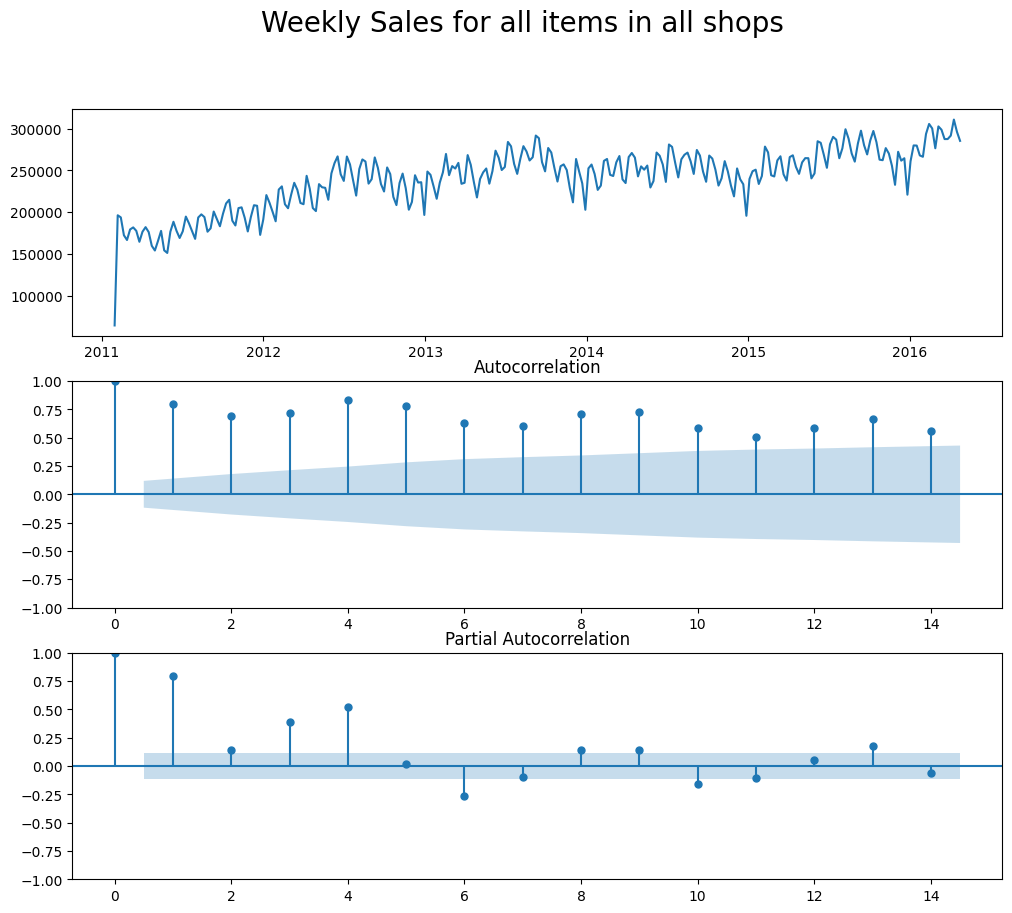

In [20]:
plot_ts_acf_pacf(y = y, title = "Weekly Sales for all items in all shops");

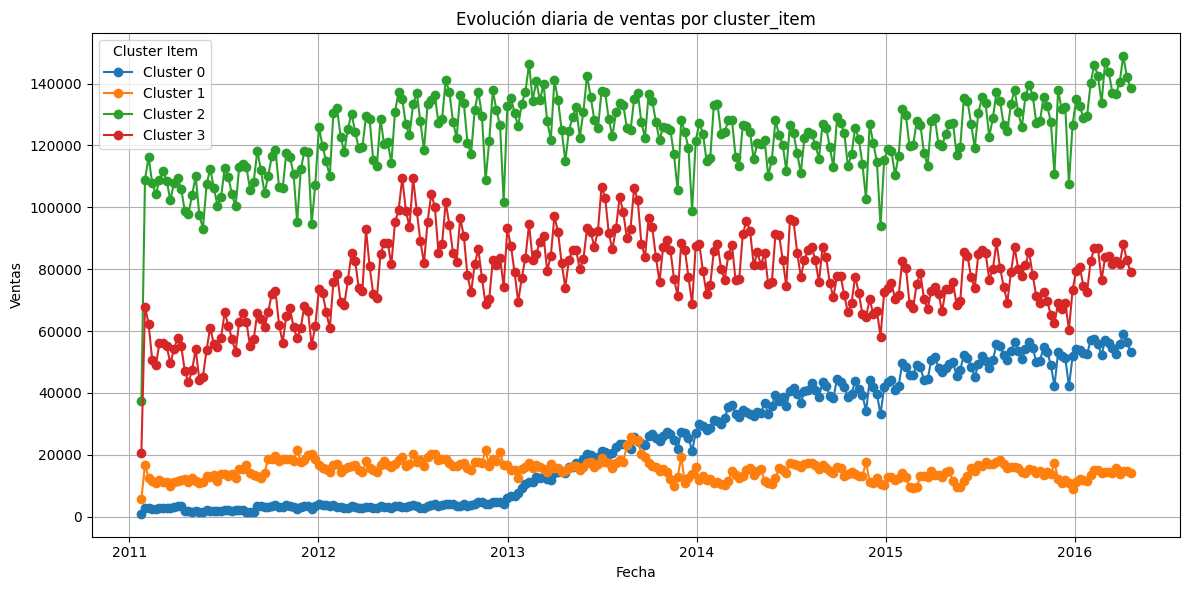

In [21]:

# Asegúrate de que la columna de fecha sea tipo datetime
df['date'] = pd.to_datetime(df['date'])

# Agrupamos las ventas por fecha y cluster_item
df_grouped = df.groupby(['date', 'cluster_item'])['n_sales'].sum().reset_index()

# Creamos el gráfico
plt.figure(figsize=(12, 6))

for cluster in df_grouped['cluster_item'].unique():
    subset = df_grouped[df_grouped['cluster_item'] == cluster]
    plt.plot(subset['date'], subset['n_sales'], marker='o', label=f'Cluster {cluster}')

plt.title('Evolución diaria de ventas por cluster_item')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.legend(title='Cluster Item')
plt.grid(True)
plt.tight_layout()
plt.show()

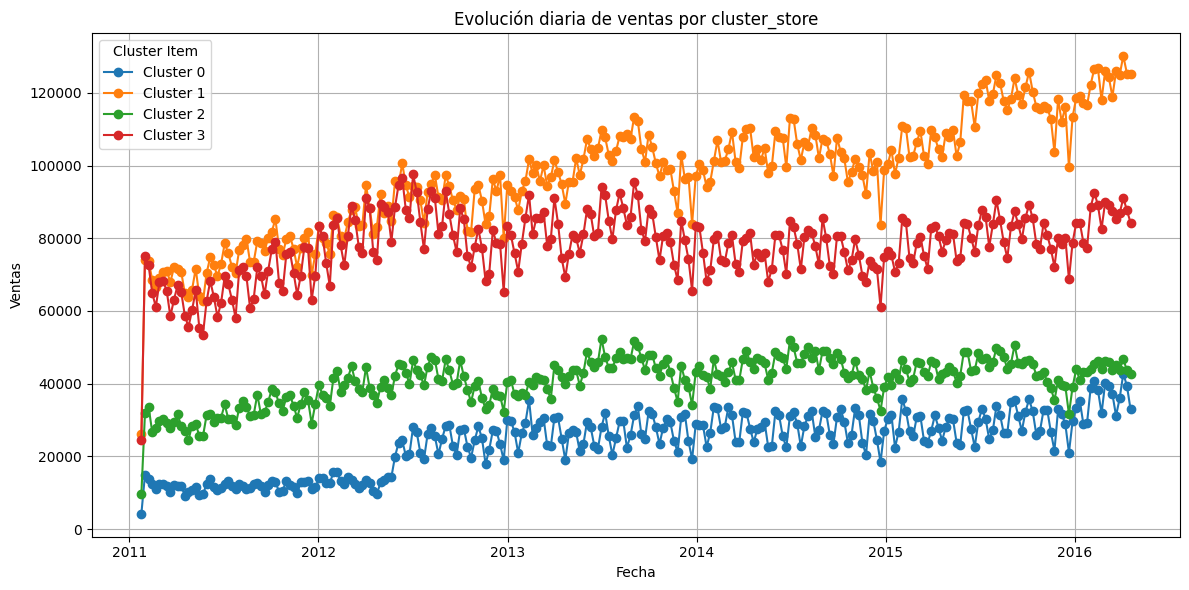

In [22]:
# Asegúrate de que la columna de fecha sea tipo datetime
df['date'] = pd.to_datetime(df['date'])

# Agrupamos las ventas por fecha y cluster_item
df_grouped = df.groupby(['date', 'cluster_store'])['n_sales'].sum().reset_index()

# Creamos el gráfico
plt.figure(figsize=(12, 6))

for cluster in df_grouped['cluster_store'].unique():
    subset = df_grouped[df_grouped['cluster_store'] == cluster]
    plt.plot(subset['date'], subset['n_sales'], marker='o', label=f'Cluster {cluster}')

plt.title('Evolución diaria de ventas por cluster_store')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.legend(title='Cluster Item')
plt.grid(True)
plt.tight_layout()
plt.show()

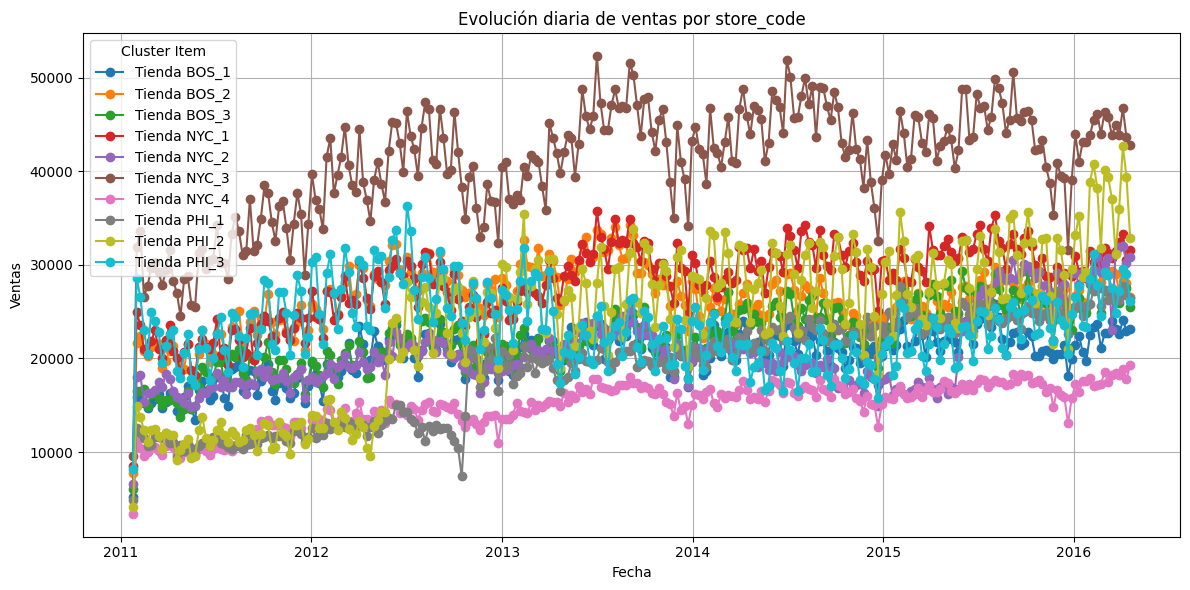

In [23]:
# Asegúrate de que la columna de fecha sea tipo datetime
df['date'] = pd.to_datetime(df['date'])

# Agrupamos las ventas por fecha y cluster_item
df_grouped = df.groupby(['date', 'store_code'])['n_sales'].sum().reset_index()

# Creamos el gráfico
plt.figure(figsize=(12, 6))

for cluster in df_grouped['store_code'].unique():
    subset = df_grouped[df_grouped['store_code'] == cluster]
    plt.plot(subset['date'], subset['n_sales'], marker='o', label=f'Tienda {cluster}')

plt.title('Evolución diaria de ventas por store_code')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.legend(title='Cluster Item')
plt.grid(True)
plt.tight_layout()
plt.show()

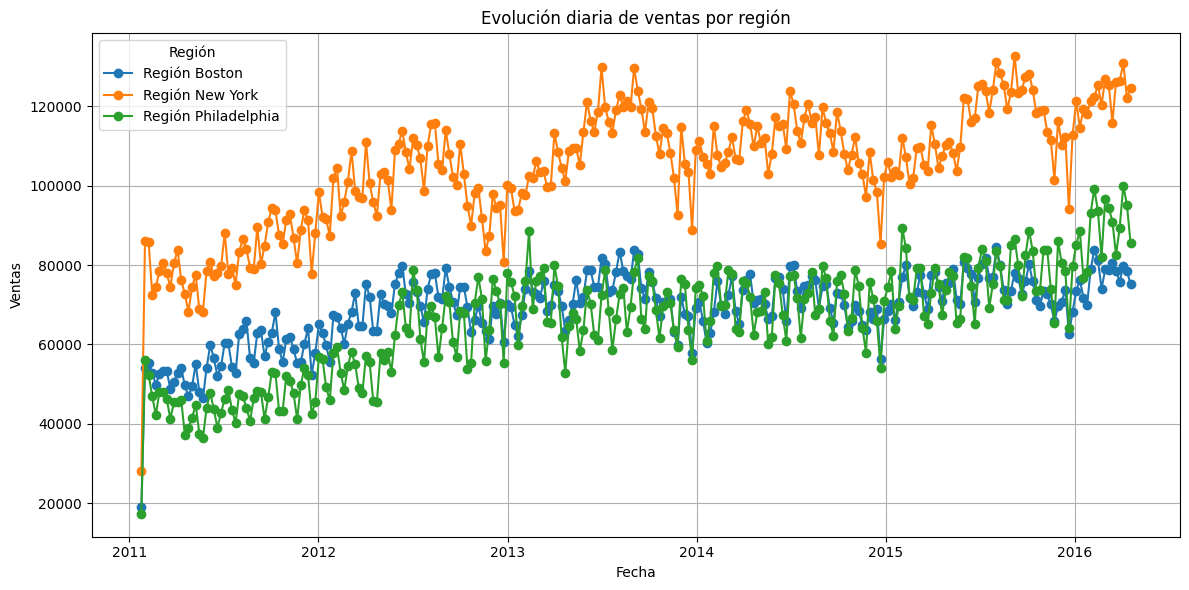

In [24]:

# Asegurarte de que 'date' sea datetime
df['date'] = pd.to_datetime(df['date'])

# Agrupar por fecha y región (sumar ventas)
df_grouped = df.groupby(['date', 'region'])['n_sales'].sum().reset_index()

# Crear gráfico
plt.figure(figsize=(12, 6))

for region in df_grouped['region'].unique():
    subset = df_grouped[df_grouped['region'] == region]
    plt.plot(subset['date'], subset['n_sales'], marker='o', label=f'Región {region}')

plt.title('Evolución diaria de ventas por región')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.legend(title='Región')
plt.grid(True)
plt.tight_layout()
plt.show()

## EDA tiendas

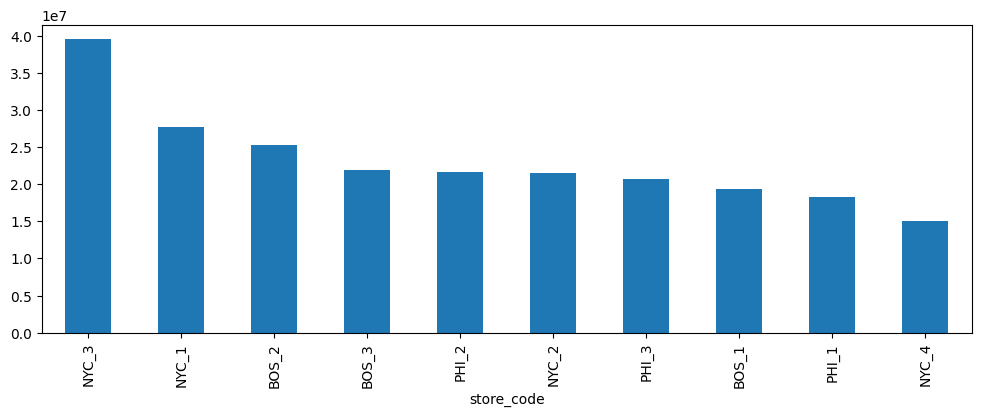

In [25]:
(
    df.
    groupby(["store_code"])
    ["revenue"].sum()
    .sort_values(ascending = False)
    .plot(kind = "bar", figsize = (12, 4))
);

## EDA departments

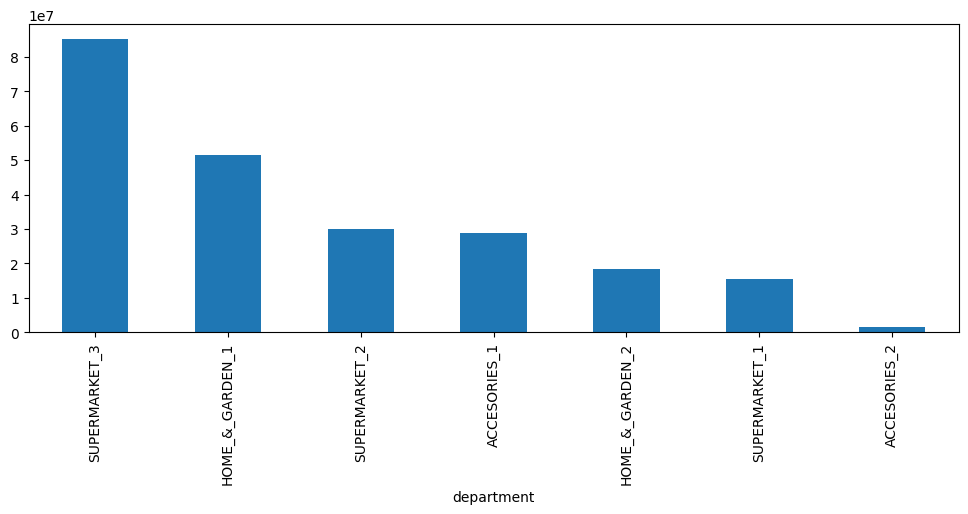

In [26]:
(
    df.
    groupby(["department"])
    ["revenue"].sum()
    .sort_values(ascending = False)
    .plot(kind = "bar", figsize = (12, 4))
);

## EDA categories

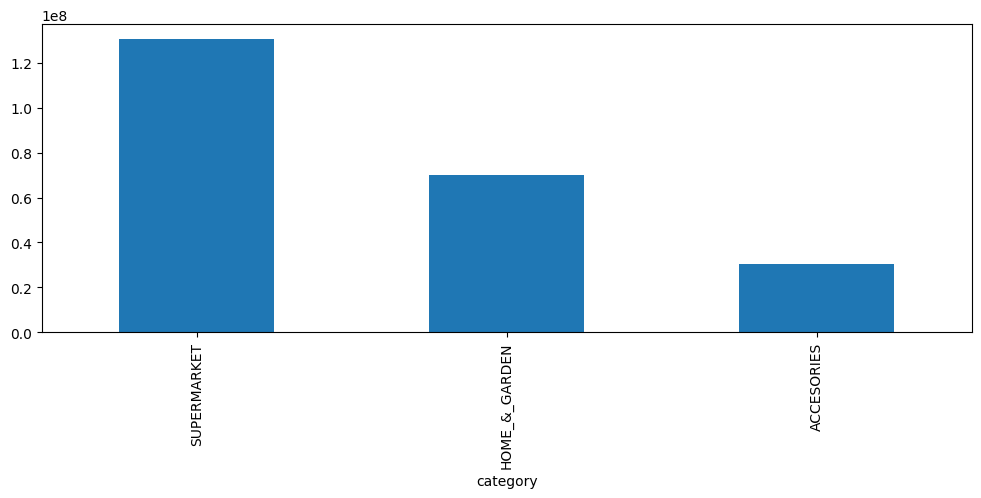

In [27]:
(
    df.
    groupby(["category"])
    ["revenue"].sum()
    .sort_values(ascending = False)
    .plot(kind = "bar", figsize = (12, 4))
);

# 5. Tratamiento variables categoricas

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8354260 entries, 0 to 8354259
Data columns (total 15 columns):
 #   Column          Dtype         
---  ------          -----         
 0   id              object        
 1   item            object        
 2   category        object        
 3   department      object        
 4   store           object        
 5   store_code      object        
 6   region          object        
 7   yearweek        object        
 8   n_sales         int64         
 9   revenue         float64       
 10  avg_sell_price  float64       
 11  event           object        
 12  cluster_store   int32         
 13  cluster_item    int32         
 14  date            datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int32(2), int64(1), object(9)
memory usage: 892.3+ MB


In [29]:
df_labels = df[["id", "item", "category", "department", "store", "store_code", "region"]].drop_duplicates().reset_index(drop=True)

### Usamos label encoder para asignar un id a cada categoria en variables categoricas

In [30]:
# Columnas categóricas a transformar
cat_cols = ["item", "category", "department", "region", "store_code"]


from sklearn.preprocessing import LabelEncoder

enc = LabelEncoder()

for col in cat_cols:
    df[col] = enc.fit_transform(df[col])

### Variable 'event'

In [31]:
df["event"].value_counts(normalize=True) * 100

event
Without event        70.437956
SuperBowl             2.189781
Valentine's Day       2.189781
St. Patrick's Day     2.189781
Easter                2.189781
Mother's Day          1.824818
Independence Day      1.824818
Ramadan starts        1.824818
Labor Day             1.824818
Green Monday          1.824818
Halloween             1.824818
Thanksgiving          1.824818
Cyber Monday          1.824818
NewYear               1.824818
Father's Day          1.459854
Super Saturday        1.459854
Christmas Day         1.459854
Name: proportion, dtype: float64

In [32]:
df["event"] = np.where(df["event"] == "Without event", 0, 1)

In [33]:
df["event"].value_counts(normalize=True) * 100

event
0    70.437956
1    29.562044
Name: proportion, dtype: float64

In [34]:
df

id  item  category  department          store  \
0         ACCESORIES_1_001_BOS_1     0         0           0      South_End   
1         ACCESORIES_1_001_BOS_1     0         0           0      South_End   
2         ACCESORIES_1_001_BOS_1     0         0           0      South_End   
3         ACCESORIES_1_001_BOS_1     0         0           0      South_End   
4         ACCESORIES_1_001_BOS_1     0         0           0      South_End   
...                          ...   ...       ...         ...            ...   
8354255  SUPERMARKET_3_827_PHI_3  3048         2           6  Queen_Village   
8354256  SUPERMARKET_3_827_PHI_3  3048         2           6  Queen_Village   
8354257  SUPERMARKET_3_827_PHI_3  3048         2           6  Queen_Village   
8354258  SUPERMARKET_3_827_PHI_3  3048         2           6  Queen_Village   
8354259  SUPERMARKET_3_827_PHI_3  3048         2           6  Queen_Village   

         store_code  region yearweek  n_sales  revenue  avg_sell_price  event  \
0                 0       0   201104        0      0.0             NaN      0   
1                 0       0   201105        0      0.0             NaN      1   
2                 0       0   201106        0      0.0             NaN      0   
3                 0       0   201107        0      0.0             NaN      1   
4                 0       0   201108        0      0.0             NaN      0   
...             ...     ...      ...      ...      ...             ...    ...   
8354255           9       2   201612       17     20.4             1.2      1   
8354256           9       2   201613       22     26.4             1.2      0   
8354257           9       2   201614        8      9.6             1.2      0   
8354258           9       2   201615        0      0.0             NaN      0   
8354259           9       2   201616        0      0.0             NaN      0   

         cluster_store  cluster_item       date  
0                    1             0 2011-01-24  
1                    1             0 2011-01-31  
2                    1             0 2011-02-07  
3                    1             0 2011-02-14  
4                    1             0 2011-02-21  
...                ...           ...        ...  
8354255              3             0 2016-03-21  
8354256              3             0 2016-03-28  
8354257              3             0 2016-04-04  
8354258              3             0 2016-04-11  
8354259              3             0 2016-04-18  

[8354260 rows x 15 columns]

In [35]:
cols_order = [
    "id", "item", "category", "department", "store_code", "region",
    "yearweek", "date", "event", "cluster_item", "cluster_store", "n_sales", "revenue", "avg_sell_price"
]

df = df[cols_order]

In [36]:
df.head(5)

id  item  category  department  store_code  region  \
0  ACCESORIES_1_001_BOS_1     0         0           0           0       0   
1  ACCESORIES_1_001_BOS_1     0         0           0           0       0   
2  ACCESORIES_1_001_BOS_1     0         0           0           0       0   
3  ACCESORIES_1_001_BOS_1     0         0           0           0       0   
4  ACCESORIES_1_001_BOS_1     0         0           0           0       0   

  yearweek       date  event  cluster_item  cluster_store  n_sales  revenue  \
0   201104 2011-01-24      0             0              1        0      0.0   
1   201105 2011-01-31      1             0              1        0      0.0   
2   201106 2011-02-07      0             0              1        0      0.0   
3   201107 2011-02-14      1             0              1        0      0.0   
4   201108 2011-02-21      0             0              1        0      0.0   

   avg_sell_price  
0             NaN  
1             NaN  
2             NaN  
3             NaN  
4             NaN

### Exploramos la variable semana del mes

In [41]:
# Si tu columna de fecha no está en datetime
df['date'] = pd.to_datetime(df['date'])

# Crear variable de mes y año (por si luego quieres agrupar)
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

# Calcular la "semana del mes"
df['week_of_month'] = df['date'].apply(lambda d: (d.day - 1) // 7 + 1)

In [42]:
df = df.drop(columns=["week_of_month", "month"])

# 6. Creacion dataframe a predecir

### Determinar numero semanas a predecir

In [43]:
weeks_predict = 4
df_weeks_future = future_yearweeks_df(last_week, weeks_predict, as_str=True)

# Crear dataframe de ids únicos
df_ids = df[["id", "item", "category", "department", "store_code","region"]].drop_duplicates()

# Cross join de id's y semanas a predecir, obteniendo df_predict
try:
    # pandas 1.2+ soporta how='cross'
    df_predict = df_ids.merge(df_weeks_future, how="cross")
except TypeError:
    # fallback si tu pandas no soporta 'cross'
    df_ids["_k"] = 1
    df_weeks_future["_k"] = 1
    df_predict = df_ids.merge(df_weeks_future, on="_k").drop(columns="_k")

# df_predict tiene columnas: id, yearweek, n_sales
print(df_predict.shape)
df_predict.head()

(121960, 7)


id  item  category  department  store_code  region  \
0  ACCESORIES_1_001_BOS_1     0         0           0           0       0   
1  ACCESORIES_1_001_BOS_1     0         0           0           0       0   
2  ACCESORIES_1_001_BOS_1     0         0           0           0       0   
3  ACCESORIES_1_001_BOS_1     0         0           0           0       0   
4  ACCESORIES_1_001_BOS_2     0         0           0           1       0   

  yearweek  
0   201617  
1   201618  
2   201619  
3   201620  
4   201617

### Asignar fecha a las nuevas semanas

In [44]:
# Asegurar tipos
df_predict["yearweek"] = df_predict["yearweek"].astype(str)

# Universo de semanas ISO en el rango
weeks_predict_all = sorted(df_predict["yearweek"].unique())
weeks_df_predict = pd.DataFrame(weeks_predict_all, columns=["yearweek"])


weeks_df_predict["date"] = weeks_df_predict["yearweek"].map(iso_yearweek_to_date)

In [45]:
df_predict = df_predict.merge(weeks_df_predict, on='yearweek', how='left')
df_predict.head(3)

id  item  category  department  store_code  region  \
0  ACCESORIES_1_001_BOS_1     0         0           0           0       0   
1  ACCESORIES_1_001_BOS_1     0         0           0           0       0   
2  ACCESORIES_1_001_BOS_1     0         0           0           0       0   

  yearweek       date  
0   201617 2016-04-25  
1   201618 2016-05-02  
2   201619 2016-05-09

In [46]:
df_predict.shape

(121960, 8)

Guardamos el numero de semana de los registros a predecir para la prediccion final.

In [47]:
predict_yearweek = df_predict[['yearweek']].copy()

In [48]:
predict_yearweek["unique_id"] = df_predict.index

In [49]:
predict_yearweek

yearweek  unique_id
0        201617          0
1        201618          1
2        201619          2
3        201620          3
4        201617          4
...         ...        ...
121955   201620     121955
121956   201617     121956
121957   201618     121957
121958   201619     121958
121959   201620     121959

[121960 rows x 2 columns]

### Adicion de variables para las futuras semanas

In [50]:
df_predict["event"] = 0
df_predict["n_sales"] = 0
df_predict["revenue"] = 0
df_predict["year"] = 2016
df_predict["avg_sell_price"] = np.nan

In [51]:
cluster_store = df[["store_code", "cluster_store"]].drop_duplicates()
cluster_item = df[["item", "cluster_item"]].drop_duplicates()

In [52]:
df_predict.shape

(121960, 13)

In [53]:
df_predict = (
    df_predict
    .merge(cluster_store, on="store_code", how="left")
    .merge(cluster_item, on="item", how="left")
)

In [54]:
df_predict.shape

(121960, 15)

In [55]:
df.head(3)

id  item  category  department  store_code  region  \
0  ACCESORIES_1_001_BOS_1     0         0           0           0       0   
1  ACCESORIES_1_001_BOS_1     0         0           0           0       0   
2  ACCESORIES_1_001_BOS_1     0         0           0           0       0   

  yearweek       date  event  cluster_item  cluster_store  n_sales  revenue  \
0   201104 2011-01-24      0             0              1        0      0.0   
1   201105 2011-01-31      1             0              1        0      0.0   
2   201106 2011-02-07      0             0              1        0      0.0   

   avg_sell_price  year  
0             NaN  2011  
1             NaN  2011  
2             NaN  2011

In [56]:
df_predict.head(3)

id  item  category  department  store_code  region  \
0  ACCESORIES_1_001_BOS_1     0         0           0           0       0   
1  ACCESORIES_1_001_BOS_1     0         0           0           0       0   
2  ACCESORIES_1_001_BOS_1     0         0           0           0       0   

  yearweek       date  event  n_sales  revenue  year  avg_sell_price  \
0   201617 2016-04-25      0        0        0  2016             NaN   
1   201618 2016-05-02      0        0        0  2016             NaN   
2   201619 2016-05-09      0        0        0  2016             NaN   

   cluster_store  cluster_item  
0              1             0  
1              1             0  
2              1             0

In [57]:
df["yearweek"] = df["yearweek"].astype(int)
df_predict["yearweek"] = df_predict["yearweek"].astype(int)

In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8354260 entries, 0 to 8354259
Data columns (total 15 columns):
 #   Column          Dtype         
---  ------          -----         
 0   id              object        
 1   item            int64         
 2   category        int64         
 3   department      int64         
 4   store_code      int64         
 5   region          int64         
 6   yearweek        int64         
 7   date            datetime64[ns]
 8   event           int64         
 9   cluster_item    int32         
 10  cluster_store   int32         
 11  n_sales         int64         
 12  revenue         float64       
 13  avg_sell_price  float64       
 14  year            int32         
dtypes: datetime64[ns](1), float64(2), int32(3), int64(8), object(1)
memory usage: 860.5+ MB


In [59]:
df_predict.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121960 entries, 0 to 121959
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   id              121960 non-null  object        
 1   item            121960 non-null  int64         
 2   category        121960 non-null  int64         
 3   department      121960 non-null  int64         
 4   store_code      121960 non-null  int64         
 5   region          121960 non-null  int64         
 6   yearweek        121960 non-null  int64         
 7   date            121960 non-null  datetime64[ns]
 8   event           121960 non-null  int64         
 9   n_sales         121960 non-null  int64         
 10  revenue         121960 non-null  int64         
 11  year            121960 non-null  int64         
 12  avg_sell_price  0 non-null       float64       
 13  cluster_store   121960 non-null  int32         
 14  cluster_item    121960 non-null  int

### Union de df historico y df a predecir

In [60]:
rows_df = df.shape[0]
rows_predict = df_predict.shape[0]
total_rows = rows_df + rows_predict
print(f"Filas en df historico: {rows_df}")
print(f"Filas en df predecir: {rows_predict}")
print(f"Filas que deben resultar despues de union: {total_rows}")

Filas en df historico: 8354260
Filas en df predecir: 121960
Filas que deben resultar despues de union: 8476220


In [61]:
df = pd.concat([df, df_predict], ignore_index=True)

In [62]:
rows_df_concat = df.shape[0]
rows_validation = total_rows - rows_df_concat
print(f"Filas en df historico: {rows_df}")
print(f"Filas en df predecir: {rows_predict}")
print(f"Filas que deben resultar despues de union: {total_rows}")
print(f"Filas resultantes despues de union: {rows_df_concat}")
print(f"Diferencia de: {rows_validation}")

Filas en df historico: 8354260
Filas en df predecir: 121960
Filas que deben resultar despues de union: 8476220
Filas resultantes despues de union: 8476220
Diferencia de: 0


### Corrección nulos precio

In [63]:
df['avg_sell_price'] = (
    df.sort_values(['id','date'])
      .groupby('id')['avg_sell_price']
      .transform('ffill')
      .reindex(df.index)   # re-alinea al índice original
)

In [64]:
df.tail(5)

id  item  category  department  store_code  \
8476215  SUPERMARKET_3_827_PHI_2  3048         2           6           8   
8476216  SUPERMARKET_3_827_PHI_3  3048         2           6           9   
8476217  SUPERMARKET_3_827_PHI_3  3048         2           6           9   
8476218  SUPERMARKET_3_827_PHI_3  3048         2           6           9   
8476219  SUPERMARKET_3_827_PHI_3  3048         2           6           9   

         region  yearweek       date  event  cluster_item  cluster_store  \
8476215       2    201620 2016-05-16      0             0              0   
8476216       2    201617 2016-04-25      0             0              3   
8476217       2    201618 2016-05-02      0             0              3   
8476218       2    201619 2016-05-09      0             0              3   
8476219       2    201620 2016-05-16      0             0              3   

         n_sales  revenue  avg_sell_price  year  
8476215        0      0.0             1.2  2016  
8476216        0      0.0             1.2  2016  
8476217        0      0.0             1.2  2016  
8476218        0      0.0             1.2  2016  
8476219        0      0.0             1.2  2016

### Hacemos copia para usar al final

In [65]:
df_copy = df.copy()

### Creación semana sin y  cos

In [66]:
df["yearweek"]

0          201104
1          201105
2          201106
3          201107
4          201108
            ...  
8476215    201620
8476216    201617
8476217    201618
8476218    201619
8476219    201620
Name: yearweek, Length: 8476220, dtype: int64

In [67]:
# Asegurar que sea string
df["yearweek"] = df["yearweek"].astype(str)

# Separar: 4 primeros dígitos = año, el resto = semana
df["year"] = df["yearweek"].str[:4].astype(int)
df["week"] = df["yearweek"].str[4:].astype(int)


In [68]:
df["week_sin"] = np.sin(2 * np.pi * df["week"] / 52)
df["week_cos"] = np.cos(2 * np.pi * df["week"] / 52)

In [69]:
df.isnull().sum()

id                      0
item                    0
category                0
department              0
store_code              0
region                  0
yearweek                0
date                    0
event                   0
cluster_item            0
cluster_store           0
n_sales                 0
revenue                 0
avg_sell_price    1775233
year                    0
week                    0
week_sin                0
week_cos                0
dtype: int64

# 7. Creacion de features para time series

## Agregación por semanas

In [70]:
features = [
    {
        "gb_list": ["item"],
        "target_column": "n_sales",
        "agg_func": "sum",
        "agg_func_name": "",  
        "nr_lags": 4,
    },
    {
        "gb_list": ["item"],
        "target_column": "n_sales",
        "agg_func": "mean",
        "agg_func_name": "",  
        "nr_lags": 4,
    },
    {
        "gb_list": ["region"],
        "target_column": "n_sales",
        "agg_func": "mean",
        "agg_func_name": "", 
        "nr_lags": 4,
    },
    {
        "gb_list": ["item", "store_code"],
        "target_column": "revenue",
        "agg_func": "mean",
        "agg_func_name": "",  
        "nr_lags": 4,
    },
    {
        "gb_list": ["store_code", "item"],
        "target_column": "n_sales",
        "agg_func": "sum",
        "agg_func_name": "",
        "nr_lags": 12,
    },
    {
        "gb_list": ["department", "store_code"],
        "target_column": "n_sales",
        "agg_func": "max",
        "agg_func_name": "",
        "nr_lags": 4,
    },
    {
        "gb_list": ["region", "store_code"],
        "target_column": "n_sales",
        "agg_func": "sum",
        "agg_func_name": "",
        "nr_lags": 4,
    }
]

In [71]:
df_features = generate_and_merge_features(df, features, verbose=True)
df_col = df.shape[1]
df_feat_col = df_features.shape[1]
dif_cols = df_feat_col-df_col
print(f"Se han creado {dif_cols} nuevas variables")

Dropping columns that might cause target leakage item_n_sales_sum
[1/7] Merge on ['item', 'date'] | new cols: ['item_n_sales_sum_lag1', 'item_n_sales_sum_lag2', 'item_n_sales_sum_lag3', 'item_n_sales_sum_lag4']
Dropping columns that might cause target leakage item_n_sales_mean
[2/7] Merge on ['item', 'date'] | new cols: ['item_n_sales_mean_lag1', 'item_n_sales_mean_lag2', 'item_n_sales_mean_lag3', 'item_n_sales_mean_lag4']
Dropping columns that might cause target leakage region_n_sales_mean
[3/7] Merge on ['region', 'date'] | new cols: ['region_n_sales_mean_lag1', 'region_n_sales_mean_lag2', 'region_n_sales_mean_lag3', 'region_n_sales_mean_lag4']
Dropping columns that might cause target leakage item_store_code_revenue_mean
[4/7] Merge on ['item', 'store_code', 'date'] | new cols: ['item_store_code_revenue_mean_lag1', 'item_store_code_revenue_mean_lag2', 'item_store_code_revenue_mean_lag3', 'item_store_code_revenue_mean_lag4']
Dropping columns that might cause target leakage store_code_

## Medias móviles

### Por unique_id

In [72]:
add_rolling_feature_inplace(
    df_features,
    target_column = "n_sales",
    groupby_cols = "id",
    window = 4,
    agg_func = "mean",
    n_lags = 1
)

In [73]:
add_rolling_feature_inplace(
    df_features,
    target_column = "n_sales",
    groupby_cols = "id",
    window = 8,
    agg_func = "mean",
    n_lags = 1
)

In [74]:
add_rolling_feature_inplace(
    df_features,
    target_column = "n_sales",
    groupby_cols = "id",
    window = 12,
    agg_func = "mean",
    n_lags = 1
)

In [75]:
add_rolling_feature_inplace(
    df_features,
    target_column = "n_sales",
    groupby_cols = "id",
    window = 24,
    agg_func = "mean",
    n_lags = 1
)

# 8. Split Train, Test y Predict

Eliminamos infinitos si los hubiese

In [76]:
df_features = df_features.replace([np.inf, -np.inf], 0)

Encodear las semanas

In [77]:

# Asegurarte de que sea string
df_features["yearweek"] = df_features["yearweek"].astype(str)

# Crear el encoder
encoder = OrdinalEncoder()

# Ajustar y transformar
df_features["yearweek_encoded"] = encoder.fit_transform(df_features[["yearweek"]])

# Verificar
print(df_features[["yearweek", "yearweek_encoded"]].head())

  yearweek  yearweek_encoded
0   201104               0.0
1   201105               1.0
2   201106               2.0
3   201107               3.0
4   201108               4.0


Ponemos variables en index que no usaremos ahora

In [78]:
df_features.set_index(["yearweek", "id"], inplace=True)

Eliminamos los nulos en precio que no sean las últimas 4 semanas

In [79]:
# Asegurar orden por fecha
df_features = df_features.sort_values("date")

# Obtener las últimas 4 fechas únicas
ultimas_fechas = df_features["date"].drop_duplicates().sort_values().iloc[-4:]

# Separar las filas de las últimas 4 fechas
mask_ultimas = df_features["date"].isin(ultimas_fechas)

# Dividir en dos partes: anteriores y últimas
df_anteriores = df_features.loc[~mask_ultimas].dropna(subset=["avg_sell_price"])
df_ultimas = df_features.loc[mask_ultimas]

# Unirlas nuevamente (manteniendo el orden)
df_features = pd.concat([df_anteriores, df_ultimas]).sort_values("date")

## Creación de Shifts para los 3 modelos desplazados

Separamos las columnas a las que afectará

In [80]:
Columnas_shift = ['item_n_sales_sum_lag1', 'item_n_sales_sum_lag2',
'item_n_sales_sum_lag3', 'item_n_sales_sum_lag4',
'item_n_sales_mean_lag1', 'item_n_sales_mean_lag2',
'item_n_sales_mean_lag3', 'item_n_sales_mean_lag4',
'region_n_sales_mean_lag1', 'region_n_sales_mean_lag2',
'region_n_sales_mean_lag3', 'region_n_sales_mean_lag4',
'item_store_code_revenue_mean_lag1',
'item_store_code_revenue_mean_lag2',
'item_store_code_revenue_mean_lag3',
'item_store_code_revenue_mean_lag4', 'store_code_item_n_sales_sum_lag1',
'store_code_item_n_sales_sum_lag2', 'store_code_item_n_sales_sum_lag3',
'store_code_item_n_sales_sum_lag4', 'store_code_item_n_sales_sum_lag5',
'store_code_item_n_sales_sum_lag6', 'store_code_item_n_sales_sum_lag7',
'store_code_item_n_sales_sum_lag8', 'store_code_item_n_sales_sum_lag9',
'store_code_item_n_sales_sum_lag10',
'store_code_item_n_sales_sum_lag11',
'store_code_item_n_sales_sum_lag12',
'department_store_code_n_sales_max_lag1',
'department_store_code_n_sales_max_lag2',
'department_store_code_n_sales_max_lag3',
'department_store_code_n_sales_max_lag4',
'region_store_code_n_sales_sum_lag1',
'region_store_code_n_sales_sum_lag2',
'region_store_code_n_sales_sum_lag3',
'region_store_code_n_sales_sum_lag4', 'id_n_sales_roll4_mean_lag1',       'id_n_sales_roll8_mean_lag1', 'id_n_sales_roll12_mean_lag1',
'id_n_sales_roll24_mean_lag1']

Creamos los diferentes data frames para entrenamientos posteriores con cada modelo

In [81]:
df_features_2 = df_features.copy()
df_features_2[Columnas_shift] = (
    df_features_2
    .sort_values(['id', 'date'])
    .groupby('id')[Columnas_shift]
    .shift(1)
)
df_features_2.rename(
    columns={col: f"{col}_shift1" for col in Columnas_shift},
    inplace=True
)



df_features_3 = df_features.copy()
df_features_3[Columnas_shift] = (
    df_features_3
    .sort_values(['id', 'date'])
    .groupby('id')[Columnas_shift]
    .shift(2)
)
df_features_3.rename(
    columns={col: f"{col}_shift2" for col in Columnas_shift},
    inplace=True
)



df_features_4 = df_features.copy()
df_features_4[Columnas_shift] = (
    df_features_4
    .sort_values(['id', 'date'])
    .groupby('id')[Columnas_shift]
    .shift(3)
)
df_features_4.rename(
    columns={col: f"{col}_shift3" for col in Columnas_shift},
    inplace=True
)

In [82]:
weeks = sorted(df_features["date"].unique())
weeks

[Timestamp('2011-01-24 00:00:00'),
 Timestamp('2011-01-31 00:00:00'),
 Timestamp('2011-02-07 00:00:00'),
 Timestamp('2011-02-14 00:00:00'),
 Timestamp('2011-02-21 00:00:00'),
 Timestamp('2011-02-28 00:00:00'),
 Timestamp('2011-03-07 00:00:00'),
 Timestamp('2011-03-14 00:00:00'),
 Timestamp('2011-03-21 00:00:00'),
 Timestamp('2011-03-28 00:00:00'),
 Timestamp('2011-04-04 00:00:00'),
 Timestamp('2011-04-11 00:00:00'),
 Timestamp('2011-04-18 00:00:00'),
 Timestamp('2011-04-25 00:00:00'),
 Timestamp('2011-05-02 00:00:00'),
 Timestamp('2011-05-09 00:00:00'),
 Timestamp('2011-05-16 00:00:00'),
 Timestamp('2011-05-23 00:00:00'),
 Timestamp('2011-05-30 00:00:00'),
 Timestamp('2011-06-06 00:00:00'),
 Timestamp('2011-06-13 00:00:00'),
 Timestamp('2011-06-20 00:00:00'),
 Timestamp('2011-06-27 00:00:00'),
 Timestamp('2011-07-04 00:00:00'),
 Timestamp('2011-07-11 00:00:00'),
 Timestamp('2011-07-18 00:00:00'),
 Timestamp('2011-07-25 00:00:00'),
 Timestamp('2011-08-01 00:00:00'),
 Timestamp('2011-08-

Creamos 5 splits para cross validation, considerando momentos de alta y baja demansa diferentes y tener una muestra más parecida al global real

También separamos las semanas para los diferentes modelos de predicción y entrenamiento

In [83]:
train_weeks = weeks[:-5]
test_weeks = weeks[-5]

train_pred_weeks = weeks[:-4]
predict_weeks = weeks[-4]
predict_2_weeks = weeks[-3]
predict_3_weeks = weeks[-2]
predict_4_weeks = weeks[-1]


train_weeks_hace_1_periodo = weeks[:-18]
test_weeks_hace_1_periodo = weeks[-18]

train_weeks_hace_2_periodo = weeks[:-31]
test_weeks_hace_2_periodo = weeks[-31]

train_weeks_hace_3_periodo = weeks[:-45]
test_weeks_hace_3_periodo = weeks[-45]

train_weeks_hace_4_periodo = weeks[:-58]
test_weeks_hace_4_periodo = weeks[-58]


print(f"Semanas para train: {train_weeks[:2]} - ... - {train_weeks[-2:]}\n")
print(f"Semanas para test: {test_weeks}\n")
print(f"Semanas para predict: {predict_weeks}")

Semanas para train: [Timestamp('2011-01-24 00:00:00'), Timestamp('2011-01-31 00:00:00')] - ... - [Timestamp('2016-04-04 00:00:00'), Timestamp('2016-04-11 00:00:00')]

Semanas para test: 2016-04-18 00:00:00

Semanas para predict: 2016-04-25 00:00:00


Guardamos las columnas que no queremos en el modelo por data lickage

In [84]:
COLS_DROP = ["revenue", "n_sales"]

In [85]:
df_features.reset_index(inplace=True)
df_features_2.reset_index(inplace=True)
df_features_3.reset_index(inplace=True)
df_features_4.reset_index(inplace=True)

Creamos todos los data frames para entrenamientos, validaciones y predicciones

In [86]:
X_train = df_features[df_features["date"].isin(train_weeks)].drop(columns = COLS_DROP, axis = 1).set_index(["yearweek", "id", "date", "avg_sell_price"])
X_test = df_features[df_features["date"]==test_weeks].drop(columns = COLS_DROP, axis = 1).set_index(["yearweek", "id", "date", "avg_sell_price"])

X_train_2_shift = df_features_2[df_features_2["date"].isin(train_weeks)].drop(columns = COLS_DROP, axis = 1).set_index(["yearweek", "id", "date", "avg_sell_price"])
X_test_2_shift = df_features_2[df_features_2["date"]==test_weeks].drop(columns = COLS_DROP, axis = 1).set_index(["yearweek", "id", "date", "avg_sell_price"])

X_train_3_shift = df_features_3[df_features_3["date"].isin(train_weeks)].drop(columns = COLS_DROP, axis = 1).set_index(["yearweek", "id", "date", "avg_sell_price"])
X_test_3_shift = df_features_3[df_features_3["date"]==test_weeks].drop(columns = COLS_DROP, axis = 1).set_index(["yearweek", "id", "date", "avg_sell_price"])

X_train_4_shift = df_features_4[df_features_4["date"].isin(train_weeks)].drop(columns = COLS_DROP, axis = 1).set_index(["yearweek", "id", "date", "avg_sell_price"])
X_test_4_shift = df_features_4[df_features_4["date"]==test_weeks].drop(columns = COLS_DROP, axis = 1).set_index(["yearweek", "id", "date", "avg_sell_price"])





X_train_pred = df_features[df_features["date"].isin(train_pred_weeks)].drop(columns = COLS_DROP, axis = 1).set_index(["yearweek", "id", "date", "avg_sell_price"])
X_pred = df_features[df_features["date"]==predict_weeks].drop(columns = COLS_DROP, axis = 1).set_index(["yearweek", "id", "date", "avg_sell_price"])

X_train_pred_2 = df_features_2[df_features_2["date"].isin(train_pred_weeks)].drop(columns = COLS_DROP, axis = 1).set_index(["yearweek", "id", "date", "avg_sell_price"])
X_pred_2 = df_features_2[df_features_2["date"]==predict_2_weeks].drop(columns = COLS_DROP, axis = 1).set_index(["yearweek", "id", "date", "avg_sell_price"])

X_train_pred_3 = df_features_3[df_features_3["date"].isin(train_pred_weeks)].drop(columns = COLS_DROP, axis = 1).set_index(["yearweek", "id", "date", "avg_sell_price"])
X_pred_3 = df_features_3[df_features_3["date"]==predict_3_weeks].drop(columns = COLS_DROP, axis = 1).set_index(["yearweek", "id", "date", "avg_sell_price"])

X_train_pred_4 = df_features_4[df_features_4["date"].isin(train_pred_weeks)].drop(columns = COLS_DROP, axis = 1).set_index(["yearweek", "id", "date", "avg_sell_price"])
X_pred_4 = df_features_4[df_features_4["date"]==predict_4_weeks].drop(columns = COLS_DROP, axis = 1).set_index(["yearweek", "id", "date", "avg_sell_price"])



X_train_1 = df_features[df_features["date"].isin(train_weeks_hace_1_periodo)].drop(columns = COLS_DROP, axis = 1).set_index(["yearweek", "id", "date", "avg_sell_price"])
X_test_1 = df_features[df_features["date"]==test_weeks_hace_1_periodo].drop(columns = COLS_DROP, axis = 1).set_index(["yearweek", "id", "date", "avg_sell_price"])

X_train_2 = df_features[df_features["date"].isin(train_weeks_hace_2_periodo)].drop(columns = COLS_DROP, axis = 1).set_index(["yearweek", "id", "date", "avg_sell_price"])
X_test_2 = df_features[df_features["date"]==test_weeks_hace_2_periodo].drop(columns = COLS_DROP, axis = 1).set_index(["yearweek", "id", "date", "avg_sell_price"])

X_train_3 = df_features[df_features["date"].isin(train_weeks_hace_3_periodo)].drop(columns = COLS_DROP, axis = 1).set_index(["yearweek", "id", "date", "avg_sell_price"])
X_test_3 = df_features[df_features["date"]==test_weeks_hace_3_periodo].drop(columns = COLS_DROP, axis = 1).set_index(["yearweek", "id", "date", "avg_sell_price"])

X_train_4 = df_features[df_features["date"].isin(train_weeks_hace_4_periodo)].drop(columns = COLS_DROP, axis = 1).set_index(["yearweek", "id", "date", "avg_sell_price"])
X_test_4 = df_features[df_features["date"]==test_weeks_hace_4_periodo].drop(columns = COLS_DROP, axis = 1).set_index(["yearweek", "id", "date", "avg_sell_price"])

Separamos todos los valores de prediccion, entreno y validación del targuet

In [87]:
y_train = df_features[df_features["date"].isin(train_weeks)]["n_sales"]
y_test = df_features[df_features["date"]==test_weeks]["n_sales"]

y_train_2_shift = df_features_2[df_features_2["date"].isin(train_weeks)]["n_sales"]
y_test_2_shift = df_features_2[df_features_2["date"]==test_weeks]["n_sales"]

y_train_3_shift = df_features_3[df_features_3["date"].isin(train_weeks)]["n_sales"]
y_test_3_shift = df_features_3[df_features_3["date"]==test_weeks]["n_sales"]

y_train_4_shift = df_features_4[df_features_4["date"].isin(train_weeks)]["n_sales"]
y_test_4_shift = df_features_4[df_features_4["date"]==test_weeks]["n_sales"]




y_train_pred_2 = df_features_2[df_features_2["date"].isin(train_pred_weeks)]["n_sales"]
y_pred_2 = df_features_2[df_features_2["date"]==predict_2_weeks]["n_sales"]

y_train_pred_3 = df_features_3[df_features_3["date"].isin(train_pred_weeks)]["n_sales"]
y_pred_3 = df_features_3[df_features_3["date"]==predict_3_weeks]["n_sales"]

y_train_pred_4 = df_features_4[df_features_4["date"].isin(train_pred_weeks)]["n_sales"]
y_pred_4 = df_features_4[df_features_4["date"]==predict_4_weeks]["n_sales"]

y_train_pred = df_features[df_features["date"].isin(train_pred_weeks)]["n_sales"]
y_pred = df_features[df_features["date"]==predict_weeks]["n_sales"]



y_train_1 = df_features[df_features["date"].isin(train_weeks_hace_1_periodo)]["n_sales"]
y_test_1 = df_features[df_features["date"]==test_weeks_hace_1_periodo]["n_sales"]

y_train_2 = df_features[df_features["date"].isin(train_weeks_hace_2_periodo)]["n_sales"]
y_test_2 = df_features[df_features["date"]==test_weeks_hace_2_periodo]["n_sales"]

y_train_3 = df_features[df_features["date"].isin(train_weeks_hace_3_periodo)]["n_sales"]
y_test_3 = df_features[df_features["date"]==test_weeks_hace_3_periodo]["n_sales"]

y_train_4 = df_features[df_features["date"].isin(train_weeks_hace_4_periodo)]["n_sales"]
y_test_4 = df_features[df_features["date"]==test_weeks_hace_4_periodo]["n_sales"]

# 9. Entrenar modelos

## Hace 4 periodos

Definimos el modelo con alta profundidad y los n_estimators optimos que hemos visto al usar early stopping

In [88]:
model_4 = xgb.XGBRegressor(
    n_estimators=300,        
    learning_rate=0.03,    
    max_depth=10,          
    subsample=0.95,        
    colsample_bytree=0.95,     
    min_child_weight=1,       
    gamma=0,                 
    reg_lambda=0.5,           
    reg_alpha=0,             
    eval_metric="rmse",
    random_state=175 
)

Entrenamos el modelo

In [89]:
model_4.fit(
    X_train_4, y_train_4,
    eval_set=[(X_train_4, y_train_4), (X_test_4, y_test_4)]
)

[0]	validation_0-rmse:26.93085	validation_1-rmse:19.87895
[1]	validation_0-rmse:26.25272	validation_1-rmse:19.35613
[2]	validation_0-rmse:25.59481	validation_1-rmse:18.83665
[3]	validation_0-rmse:24.96178	validation_1-rmse:18.36977
[4]	validation_0-rmse:24.34780	validation_1-rmse:17.90338
[5]	validation_0-rmse:23.75648	validation_1-rmse:17.45069
[6]	validation_0-rmse:23.18450	validation_1-rmse:17.04615
[7]	validation_0-rmse:22.63200	validation_1-rmse:16.65448
[8]	validation_0-rmse:22.10034	validation_1-rmse:16.24626
[9]	validation_0-rmse:21.58251	validation_1-rmse:15.85562
[10]	validation_0-rmse:21.08725	validation_1-rmse:15.48481
[11]	validation_0-rmse:20.62019	validation_1-rmse:15.13112
[12]	validation_0-rmse:20.15148	validation_1-rmse:14.80453
[13]	validation_0-rmse:19.70647	validation_1-rmse:14.46336
[14]	validation_0-rmse:19.27698	validation_1-rmse:14.12944
[15]	validation_0-rmse:18.86214	validation_1-rmse:13.84117
[16]	validation_0-rmse:18.46378	validation_1-rmse:13.54348
[17]	va

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.95, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.03, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=175, ...)

### Feature importance

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

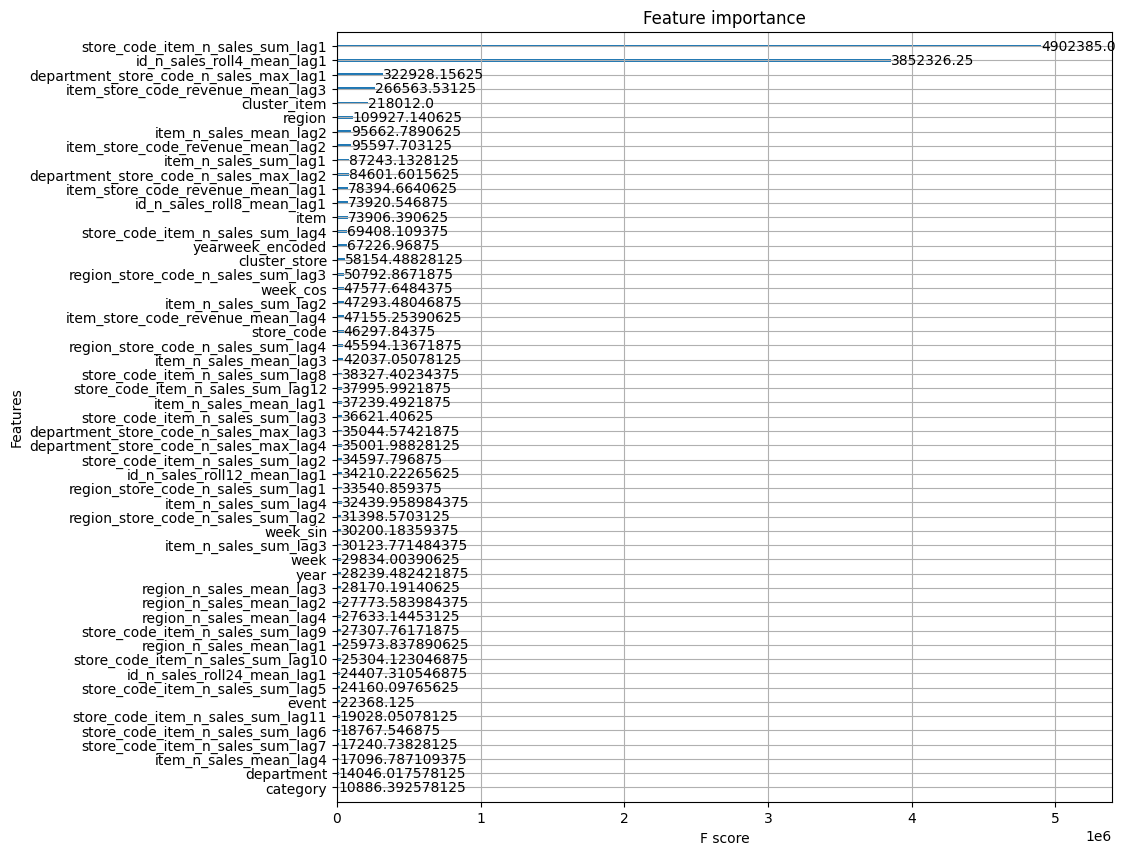

In [90]:
fig, ax = plt.subplots(figsize = (10, 10))
xgb.plot_importance(model_4, importance_type = "gain", ax = ax)

### Calculamos métricas para luego

In [91]:
Y_train_4_predict = model_4.predict(X_train_4)
Y_test_4_predict = model_4.predict(X_test_4)

rmse_train_4 = np.sqrt(
    mean_squared_error(
        y_true = y_train_4,
        y_pred = Y_train_4_predict
    )
)

rmse_test_4 = np.sqrt(
    mean_squared_error(
        y_true = y_test_4,
        y_pred = Y_test_4_predict
    )
)

rmse_train_4= str(round(rmse_train_4, 3))
rmse_test_4 = str(round(rmse_test_4, 3))

In [92]:

# Predicciones
Y_train_4_predict = model_4.predict(X_train_4)
Y_test_4_predict  = model_4.predict(X_test_4)

def smape(y_true, y_pred, epsilon=1e-8):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    denom = np.abs(y_true) + np.abs(y_pred)
    diff  = np.abs(y_true - y_pred)
    # sMAPE en [0, 2]; multiplicamos por 100 para porcentaje [0%, 200%]
    return np.mean(2.0 * diff / np.maximum(denom, epsilon)) * 100.0

smape_train_4 = smape(y_train_4, Y_train_4_predict)
smape_test_4  = smape(y_test_4,  Y_test_4_predict)

smape_train_4 = str(round(smape_train_4, 3))
smape_test_4  = str(round(smape_test_4, 3))

## Modelo hace 3 periodos

Definimos el modelo con alta profundidad y los n_estimators optimos que hemos visto al usar early stopping

In [93]:
model_3 = xgb.XGBRegressor(
    n_estimators=300,        
    learning_rate=0.03,    
    max_depth=10,          
    subsample=0.95,        
    colsample_bytree=0.95,     
    min_child_weight=1,       
    gamma=0,                 
    reg_lambda=0.5,           
    reg_alpha=0,             
    eval_metric="rmse",
    random_state=175
)

Entrenamos el modelo

In [94]:
model_3.fit(
    X_train_3, y_train_3,
    eval_set=[(X_train_3, y_train_3), (X_test_3, y_test_3)]
)

[0]	validation_0-rmse:26.53895	validation_1-rmse:23.51743
[1]	validation_0-rmse:25.87031	validation_1-rmse:22.91402
[2]	validation_0-rmse:25.22016	validation_1-rmse:22.33769
[3]	validation_0-rmse:24.59690	validation_1-rmse:21.77700
[4]	validation_0-rmse:23.99031	validation_1-rmse:21.23581
[5]	validation_0-rmse:23.40670	validation_1-rmse:20.70850
[6]	validation_0-rmse:22.83981	validation_1-rmse:20.19639
[7]	validation_0-rmse:22.29362	validation_1-rmse:19.69355
[8]	validation_0-rmse:21.77092	validation_1-rmse:19.22767
[9]	validation_0-rmse:21.26093	validation_1-rmse:18.76312
[10]	validation_0-rmse:20.76897	validation_1-rmse:18.30995
[11]	validation_0-rmse:20.30874	validation_1-rmse:17.88388
[12]	validation_0-rmse:19.84798	validation_1-rmse:17.47385
[13]	validation_0-rmse:19.40977	validation_1-rmse:17.07996
[14]	validation_0-rmse:18.98329	validation_1-rmse:16.70133
[15]	validation_0-rmse:18.57190	validation_1-rmse:16.32272
[16]	validation_0-rmse:18.17657	validation_1-rmse:15.97088
[17]	va

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.95, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.03, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=175, ...)

### Feature importance

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

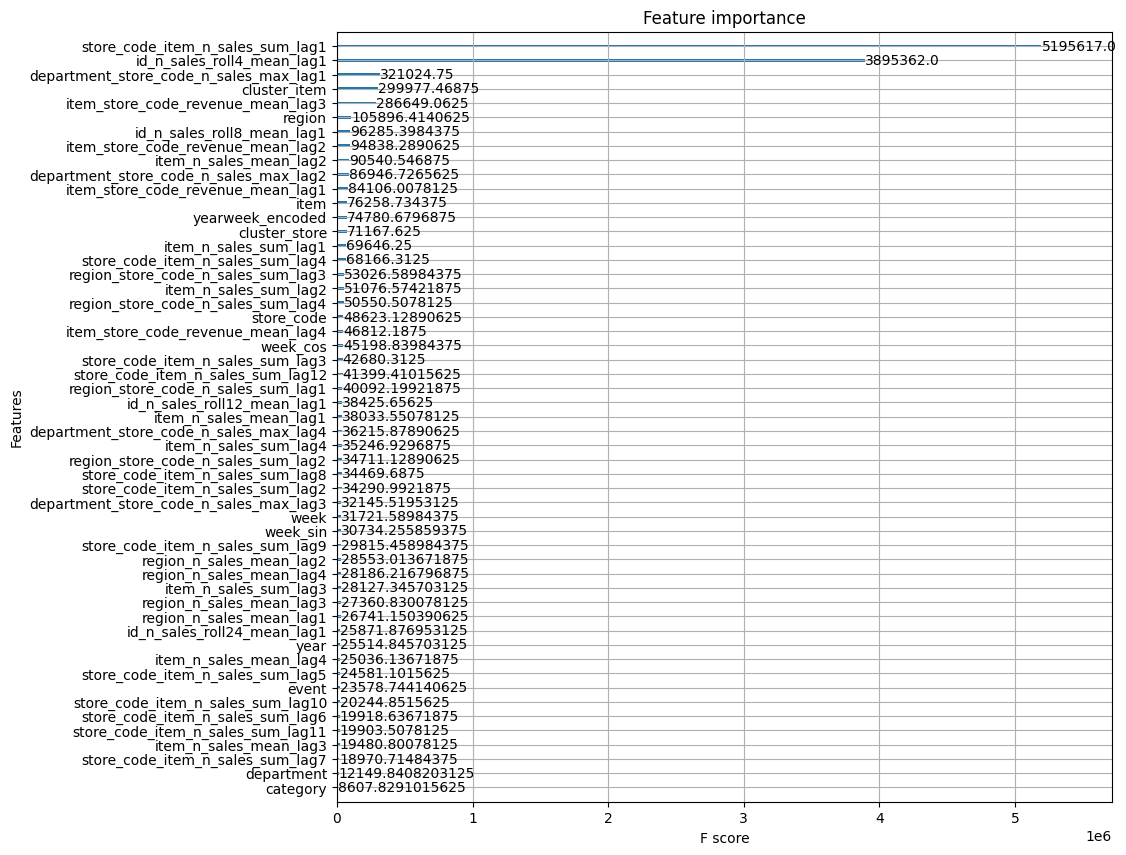

In [95]:
fig, ax = plt.subplots(figsize = (10, 10))
xgb.plot_importance(model_3, importance_type = "gain", ax = ax)

### Calculamos métricas para luego

In [96]:
Y_train_3_predict = model_3.predict(X_train_3)
Y_test_3_predict = model_3.predict(X_test_3)

rmse_train_3 = np.sqrt(
    mean_squared_error(
        y_true = y_train_3,
        y_pred = Y_train_3_predict
    )
)

rmse_test_3 = np.sqrt(
    mean_squared_error(
        y_true = y_test_3,
        y_pred = Y_test_3_predict
    )
)

rmse_train_3= str(round(rmse_train_3, 3))
rmse_test_3 = str(round(rmse_test_3, 3))

In [97]:

# Predicciones
Y_train_3_predict = model_3.predict(X_train_3)
Y_test_3_predict  = model_3.predict(X_test_3)

def smape(y_true, y_pred, epsilon=1e-8):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    denom = np.abs(y_true) + np.abs(y_pred)
    diff  = np.abs(y_true - y_pred)
    # sMAPE en [0, 2]; multiplicamos por 100 para porcentaje [0%, 200%]
    return np.mean(2.0 * diff / np.maximum(denom, epsilon)) * 100.0

smape_train_3 = smape(y_train_3, Y_train_3_predict)
smape_test_3  = smape(y_test_3,  Y_test_3_predict)

smape_train_3 = str(round(smape_train_3, 3))
smape_test_3  = str(round(smape_test_3, 3))

## Modelo hace 2 periodos

In [98]:
model_2 = xgb.XGBRegressor(
    n_estimators=500,        
    learning_rate=0.03,    
    max_depth=10,          
    subsample=0.95,        
    colsample_bytree=0.95,     
    min_child_weight=1,       
    gamma=0,                 
    reg_lambda=0.5,           
    reg_alpha=0,             
    eval_metric="rmse",
    random_state=175
)

In [99]:
model_2.fit(
    X_train_2, y_train_2,
    eval_set=[(X_train_2, y_train_2), (X_test_2, y_test_2)]
)

[0]	validation_0-rmse:26.26321	validation_1-rmse:20.03113
[1]	validation_0-rmse:25.60085	validation_1-rmse:19.47480
[2]	validation_0-rmse:24.95673	validation_1-rmse:18.92111
[3]	validation_0-rmse:24.33976	validation_1-rmse:18.40336
[4]	validation_0-rmse:23.73787	validation_1-rmse:17.90255
[5]	validation_0-rmse:23.16002	validation_1-rmse:17.42362
[6]	validation_0-rmse:22.59776	validation_1-rmse:16.94535
[7]	validation_0-rmse:22.05608	validation_1-rmse:16.49457
[8]	validation_0-rmse:21.53789	validation_1-rmse:16.06046
[9]	validation_0-rmse:21.03102	validation_1-rmse:15.64419
[10]	validation_0-rmse:20.54301	validation_1-rmse:15.25033
[11]	validation_0-rmse:20.08705	validation_1-rmse:14.86721
[12]	validation_0-rmse:19.63151	validation_1-rmse:14.48648
[13]	validation_0-rmse:19.19416	validation_1-rmse:14.13862
[14]	validation_0-rmse:18.77014	validation_1-rmse:13.79253
[15]	validation_0-rmse:18.36376	validation_1-rmse:13.45205
[16]	validation_0-rmse:17.97205	validation_1-rmse:13.12983
[17]	va

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.95, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.03, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=175, ...)

### Feature importance

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

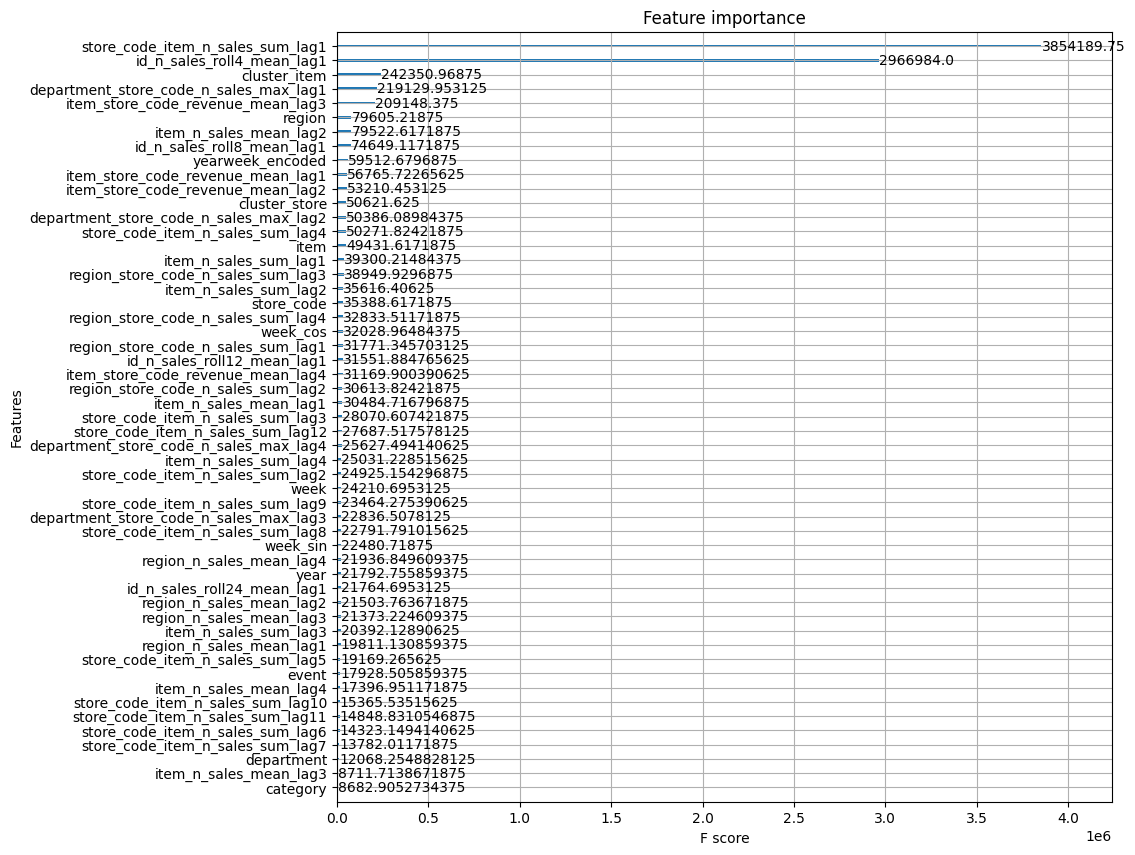

In [100]:
fig, ax = plt.subplots(figsize = (10, 10))
xgb.plot_importance(model_2, importance_type = "gain", ax = ax)

In [101]:
Y_train_2_predict = model_2.predict(X_train_2)
Y_test_2_predict = model_2.predict(X_test_2)

rmse_train_2 = np.sqrt(
    mean_squared_error(
        y_true = y_train_2,
        y_pred = Y_train_2_predict
    )
)

rmse_test_2 = np.sqrt(
    mean_squared_error(
        y_true = y_test_2,
        y_pred = Y_test_2_predict
    )
)

rmse_train_2= str(round(rmse_train_2, 3))
rmse_test_2 = str(round(rmse_test_2, 3))

In [102]:

# Predicciones
Y_train_2_predict = model_2.predict(X_train_2)
Y_test_2_predict  = model_2.predict(X_test_2)

def smape(y_true, y_pred, epsilon=1e-8):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    denom = np.abs(y_true) + np.abs(y_pred)
    diff  = np.abs(y_true - y_pred)
    # sMAPE en [0, 2]; multiplicamos por 100 para porcentaje [0%, 200%]
    return np.mean(2.0 * diff / np.maximum(denom, epsilon)) * 100.0

smape_train_2 = smape(y_train_2, Y_train_2_predict)
smape_test_2  = smape(y_test_2,  Y_test_2_predict)

smape_train_2 = str(round(smape_train_2, 3))
smape_test_2  = str(round(smape_test_2, 3))

## Modelo hace 1 periodo

In [103]:
model_1 = xgb.XGBRegressor(
    n_estimators=500,        
    learning_rate=0.03,    
    max_depth=10,          
    subsample=0.95,        
    colsample_bytree=0.95,     
    min_child_weight=1,       
    gamma=0,                 
    reg_lambda=0.5,           
    reg_alpha=0,             
    eval_metric="rmse",
    random_state=175
)

In [104]:
model_1.fit(
    X_train_1, y_train_1,
    eval_set=[(X_train_1, y_train_1), (X_test_1, y_test_1)]
)

[0]	validation_0-rmse:25.89339	validation_1-rmse:19.52884
[1]	validation_0-rmse:25.24180	validation_1-rmse:18.99627
[2]	validation_0-rmse:24.60681	validation_1-rmse:18.49041
[3]	validation_0-rmse:23.99903	validation_1-rmse:18.00845
[4]	validation_0-rmse:23.40706	validation_1-rmse:17.54649
[5]	validation_0-rmse:22.83908	validation_1-rmse:17.09270
[6]	validation_0-rmse:22.28542	validation_1-rmse:16.65005
[7]	validation_0-rmse:21.75285	validation_1-rmse:16.21677
[8]	validation_0-rmse:21.24242	validation_1-rmse:15.81794
[9]	validation_0-rmse:20.74481	validation_1-rmse:15.42397
[10]	validation_0-rmse:20.26440	validation_1-rmse:15.03384
[11]	validation_0-rmse:19.81561	validation_1-rmse:14.67769
[12]	validation_0-rmse:19.36712	validation_1-rmse:14.32059
[13]	validation_0-rmse:18.93584	validation_1-rmse:13.97343
[14]	validation_0-rmse:18.51976	validation_1-rmse:13.65477
[15]	validation_0-rmse:18.11930	validation_1-rmse:13.33770
[16]	validation_0-rmse:17.73418	validation_1-rmse:13.04348
[17]	va

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.95, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.03, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=175, ...)

### Feature importance

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

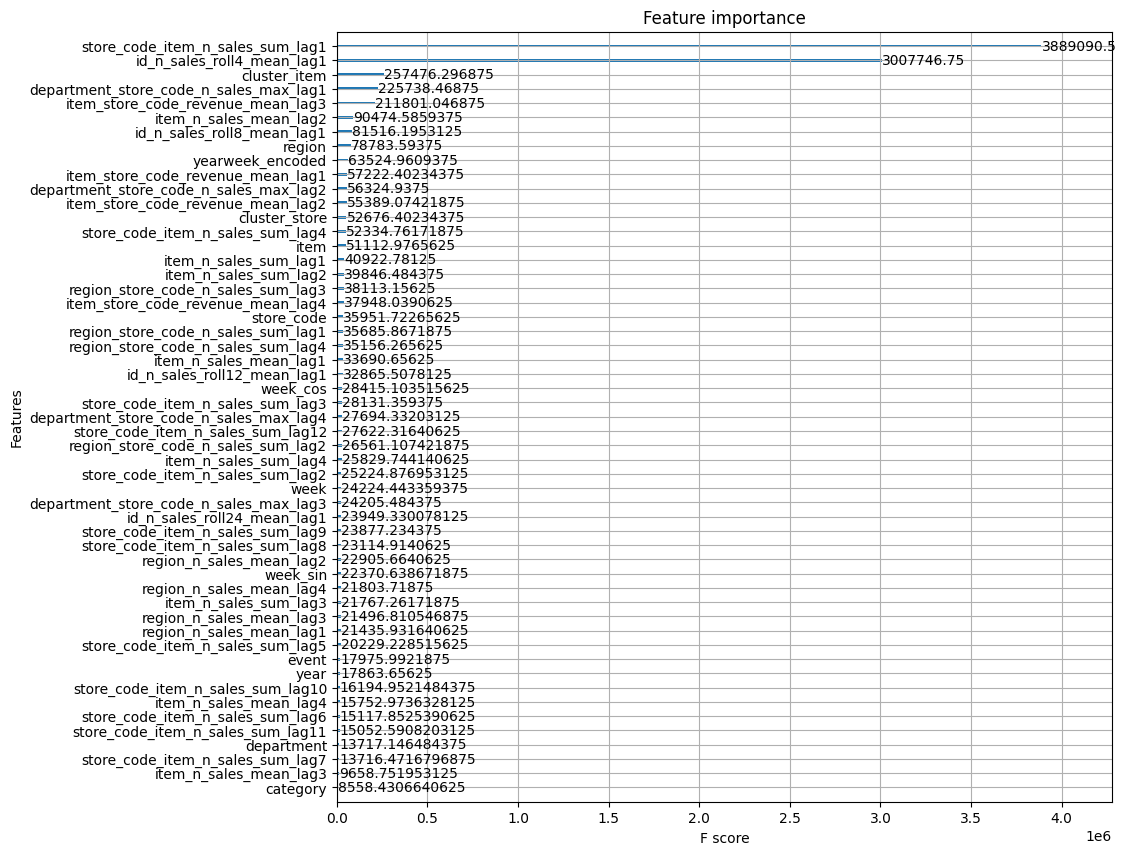

In [105]:
fig, ax = plt.subplots(figsize = (10, 10))
xgb.plot_importance(model_1, importance_type = "gain", ax = ax)

In [106]:
Y_train_1_predict = model_1.predict(X_train_1)
Y_test_1_predict = model_1.predict(X_test_1)

rmse_train_1 = np.sqrt(
    mean_squared_error(
        y_true = y_train_1,
        y_pred = Y_train_1_predict
    )
)

rmse_test_1 = np.sqrt(
    mean_squared_error(
        y_true = y_test_1,
        y_pred = Y_test_1_predict
    )
)

rmse_train_1= str(round(rmse_train_1, 3))
rmse_test_1 = str(round(rmse_test_1, 3))

In [107]:

# Predicciones
Y_train_1_predict = model_1.predict(X_train_1)
Y_test_1_predict  = model_1.predict(X_test_1)

def smape(y_true, y_pred, epsilon=1e-8):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    denom = np.abs(y_true) + np.abs(y_pred)
    diff  = np.abs(y_true - y_pred)
    # sMAPE en [0, 2]; multiplicamos por 100 para porcentaje [0%, 200%]
    return np.mean(2.0 * diff / np.maximum(denom, epsilon)) * 100.0

smape_train_1 = smape(y_train_1, Y_train_1_predict)
smape_test_1  = smape(y_test_1,  Y_test_1_predict)

smape_train_1 = str(round(smape_train_1, 3))
smape_test_1  = str(round(smape_test_1, 3))

## Modelo último periodo de validación

In [108]:
model_completo = xgb.XGBRegressor(
    n_estimators=500,        
    learning_rate=0.03,    
    max_depth=10,          
    subsample=0.95,        
    colsample_bytree=0.95,     
    min_child_weight=1,       
    gamma=0,                 
    reg_lambda=0.5,           
    reg_alpha=0,             
    eval_metric="rmse",
    random_state=175 
)

In [109]:
model_completo.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)]
)

[0]	validation_0-rmse:25.63612	validation_1-rmse:19.94626
[1]	validation_0-rmse:24.99035	validation_1-rmse:19.36793
[2]	validation_0-rmse:24.36276	validation_1-rmse:18.80441
[3]	validation_0-rmse:23.76260	validation_1-rmse:18.27262
[4]	validation_0-rmse:23.17602	validation_1-rmse:17.74834
[5]	validation_0-rmse:22.61339	validation_1-rmse:17.24359
[6]	validation_0-rmse:22.06554	validation_1-rmse:16.76189
[7]	validation_0-rmse:21.53742	validation_1-rmse:16.29206
[8]	validation_0-rmse:21.03168	validation_1-rmse:15.84097
[9]	validation_0-rmse:20.53995	validation_1-rmse:15.40510
[10]	validation_0-rmse:20.06543	validation_1-rmse:14.99066
[11]	validation_0-rmse:19.62122	validation_1-rmse:14.60201
[12]	validation_0-rmse:19.17743	validation_1-rmse:14.21585
[13]	validation_0-rmse:18.74940	validation_1-rmse:13.82906
[14]	validation_0-rmse:18.33733	validation_1-rmse:13.46666
[15]	validation_0-rmse:17.94102	validation_1-rmse:13.12119
[16]	validation_0-rmse:17.55960	validation_1-rmse:12.78426
[17]	va

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.95, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.03, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=175, ...)

### Feature importance

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

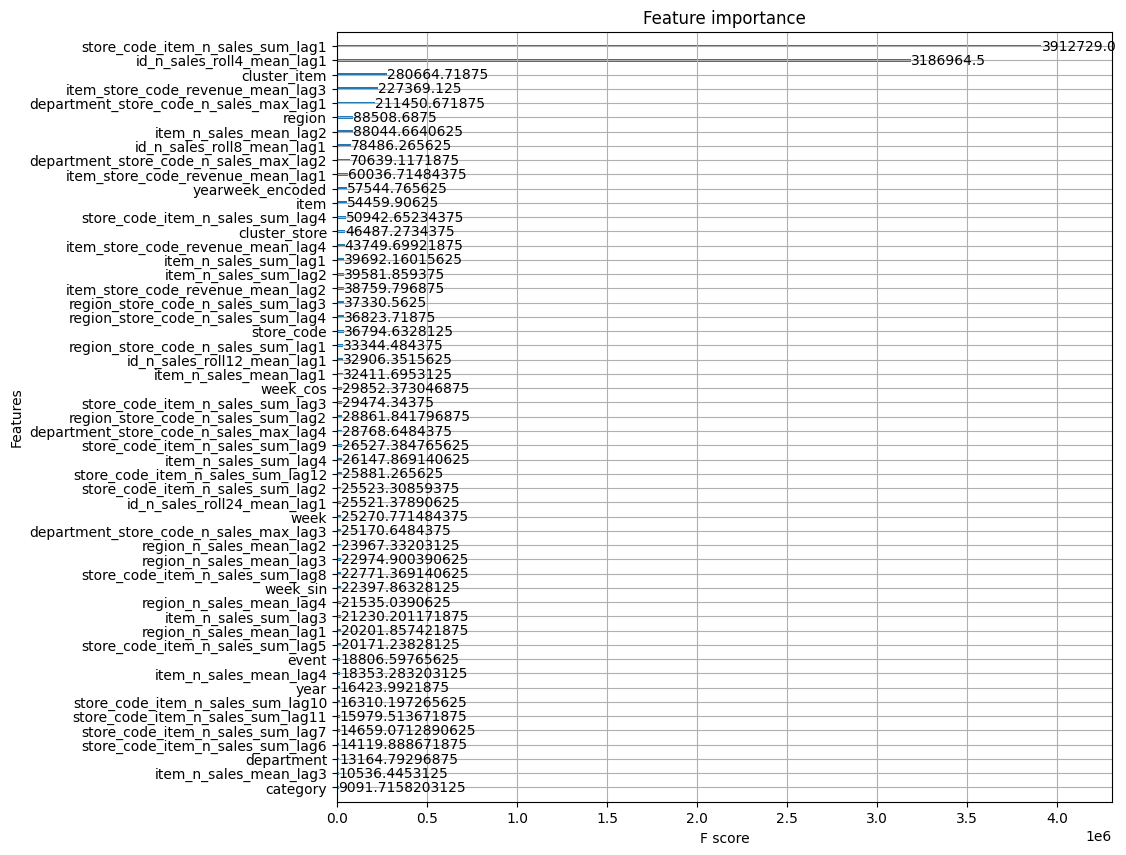

In [110]:
fig, ax = plt.subplots(figsize = (10, 10))
xgb.plot_importance(model_completo, importance_type = "gain", ax = ax)

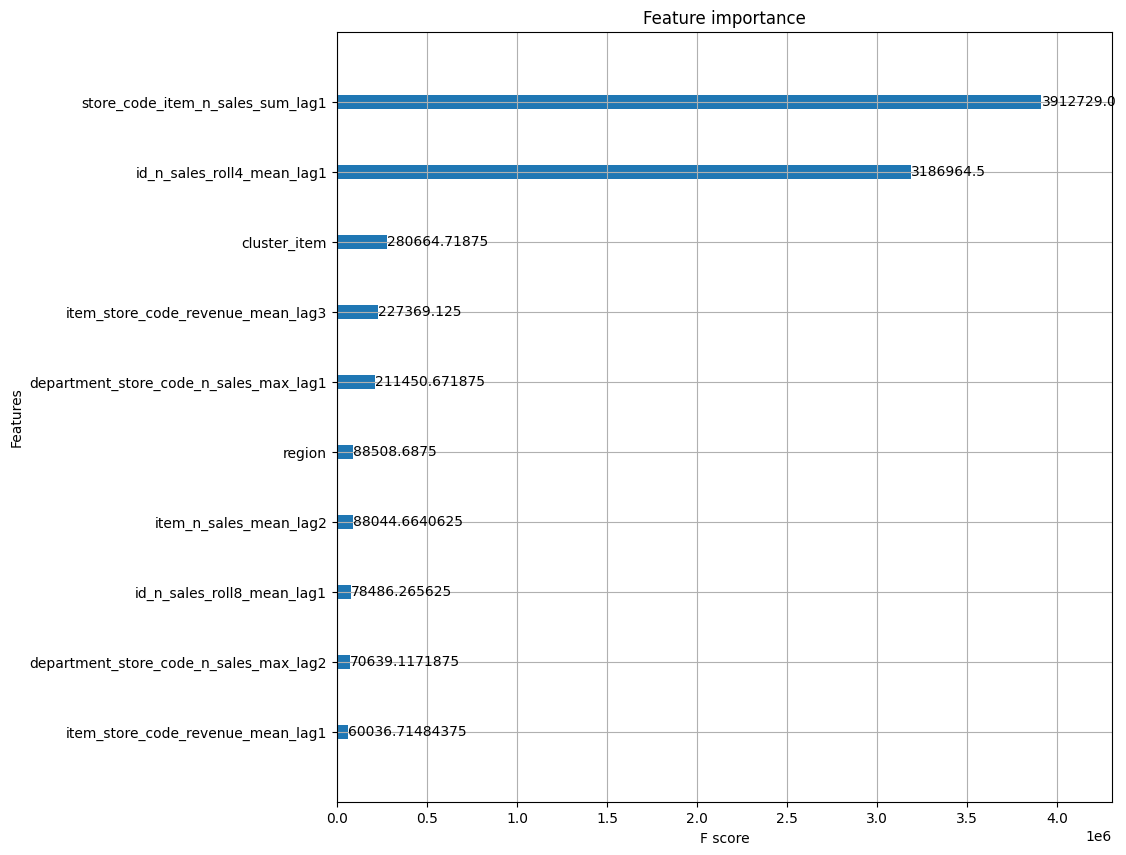

In [111]:
fig, ax = plt.subplots(figsize=(10, 10))
xgb.plot_importance(model_completo, 
                    importance_type="gain", 
                    ax=ax, 
                    max_num_features=10)
plt.show()

In [112]:
Y_test_predict = model_completo.predict(X_test)
Y_test_predict

array([30.43767  , 12.01736  , 15.026121 , ..., 35.22996  ,  1.3737012,
       13.123365 ], shape=(30490,), dtype=float32)

In [113]:
X_test = X_test.reset_index()

In [114]:
X_test = X_test.set_index(["id", "yearweek", "date", "avg_sell_price"])

### Medicion RMSE

In [115]:
Y_train_predict = model_completo.predict(X_train)
Y_test_predict = model_completo.predict(X_test)

rmse_train = np.sqrt(
    mean_squared_error(
        y_true = y_train,
        y_pred = Y_train_predict
    )
)

rmse_test = np.sqrt(
    mean_squared_error(
        y_true = y_test,
        y_pred = Y_test_predict
    )
)

rmse_train= str(round(rmse_train, 3))
rmse_test = str(round(rmse_test, 3))

In [116]:
rmse_train

'7.109'

In [117]:
rmse_test

'6.509'

Cálculo RMSE ponderado

In [118]:
rmse_test_4 = float(rmse_test_4)
rmse_test_3 = float(rmse_test_3)
rmse_test_2 = float(rmse_test_2)
rmse_test = float(rmse_test)
rmse_test_1 = float(rmse_test_1)

In [119]:
rmse_test_1

6.829

In [120]:
rmse_test_2

6.785

In [121]:
rmse_test_3

7.855

In [122]:
rmse_test_4

7.724

In [123]:
rmse_test

6.509

In [124]:
RMSE_TOTAL = (rmse_test_1*0.3)+(rmse_test_4*0.05)+(rmse_test_3*0.1)+((rmse_test)*0.35)+(rmse_test_2*0.2)

print(RMSE_TOTAL)

6.85555


## Error por cada valor - para extraer después

Reconstruimos ventas originales y ventas estimadas completas

In [125]:
df_ventas_origen_copy = df_copy.copy()

In [126]:
X_test.reset_index(inplace=True)
X_test_1.reset_index(inplace=True)
X_test_2.reset_index(inplace=True)
X_test_3.reset_index(inplace=True)
X_test_4.reset_index(inplace=True)

In [127]:
df_features

yearweek                         id  item  category  department  \
0         201104    SUPERMARKET_2_134_BOS_1  1960         2           5   
1         201104  HOME_&_GARDEN_2_369_PHI_3  1464         1           3   
2         201104     ACCESORIES_1_106_BOS_3   101         0           0   
3         201104  HOME_&_GARDEN_2_134_BOS_2  1230         1           3   
4         201104  HOME_&_GARDEN_1_460_PHI_1  1015         1           2   
...          ...                        ...   ...       ...         ...   
6700982   201620     ACCESORIES_1_023_PHI_1    22         0           0   
6700983   201620     ACCESORIES_1_023_NYC_4    22         0           0   
6700984   201620     ACCESORIES_1_023_NYC_3    22         0           0   
6700985   201620     ACCESORIES_1_018_PHI_2    17         0           0   
6700986   201620    SUPERMARKET_3_827_PHI_3  3048         2           6   

         store_code  region       date  event  cluster_item  ...  \
0                 0       0 2011-01-24      0             2  ...   
1                 9       2 2011-01-24      0             2  ...   
2                 2       0 2011-01-24      0             0  ...   
3                 1       0 2011-01-24      0             2  ...   
4                 7       2 2011-01-24      0             2  ...   
...             ...     ...        ...    ...           ...  ...   
6700982           7       2 2016-05-16      0             2  ...   
6700983           6       1 2016-05-16      0             2  ...   
6700984           5       1 2016-05-16      0             2  ...   
6700985           8       2 2016-05-16      0             0  ...   
6700986           9       2 2016-05-16      0             0  ...   

         department_store_code_n_sales_max_lag4  \
0                                           NaN   
1                                           NaN   
2                                           NaN   
3                                           NaN   
4                                           NaN   
...                                         ...   
6700982                                    69.0   
6700983                                    98.0   
6700984                                   158.0   
6700985                                    51.0   
6700986                                   593.0   

         region_store_code_n_sales_sum_lag1  \
0                                       NaN   
1                                       NaN   
2                                       NaN   
3                                       NaN   
4                                       NaN   
...                                     ...   
6700982                                 0.0   
6700983                                 0.0   
6700984                                 0.0   
6700985                                 0.0   
6700986                                 0.0   

         region_store_code_n_sales_sum_lag2  \
0                                       NaN   
1                                       NaN   
2                                       NaN   
3                                       NaN   
4                                       NaN   
...                                     ...   
6700982                                 0.0   
6700983                                 0.0   
6700984                                 0.0   
6700985                                 0.0   
6700986                                 0.0   

         region_store_code_n_sales_sum_lag3  \
0                                       NaN   
1                                       NaN   
2                                       NaN   
3                                       NaN   
4                                       NaN   
...                                     ...   
6700982                                 0.0   
6700983                                 0.0   
6700984                                 0.0   
6700985                                 0.0   
6700986                       

In [128]:
Y_test_predict

array([30.43767  , 12.01736  , 15.026121 , ..., 35.22996  ,  1.3737012,
       13.123365 ], shape=(30490,), dtype=float32)

In [129]:
X_test["n_sales_pred"] = np.asarray(Y_test_predict).ravel()
X_test["n_sales_true"] = np.asarray(y_test).ravel()
X_test_1["n_sales_pred"] = np.asarray(Y_test_1_predict).ravel()
X_test_1["n_sales_true"] = np.asarray(y_test_1).ravel()
X_test_2["n_sales_pred"] = np.asarray(Y_test_2_predict).ravel()
X_test_2["n_sales_true"] = np.asarray(y_test_2).ravel()
X_test_3["n_sales_pred"] = np.asarray(Y_test_3_predict).ravel()
X_test_3["n_sales_true"] = np.asarray(y_test_3).ravel()
X_test_4["n_sales_pred"] = np.asarray(Y_test_4_predict).ravel()
X_test_4["n_sales_true"] = np.asarray(y_test_4).ravel()

In [130]:
X_test["yearweek"] = X_test["yearweek"].astype(int)
X_test["id_yearweek"] = X_test["id"].astype(str) + "_" + X_test["yearweek"].astype(str)
X_test_1["yearweek"] = X_test_1["yearweek"].astype(int)
X_test_1["id_yearweek"] = X_test_1["id"].astype(str) + "_" + X_test_1["yearweek"].astype(str)
X_test_2["yearweek"] = X_test_2["yearweek"].astype(int)
X_test_2["id_yearweek"] = X_test_2["id"].astype(str) + "_" + X_test_2["yearweek"].astype(str)
X_test_3["yearweek"] = X_test_3["yearweek"].astype(int)
X_test_3["id_yearweek"] = X_test_3["id"].astype(str) + "_" + X_test_3["yearweek"].astype(str)
X_test_4["yearweek"] = X_test_4["yearweek"].astype(int)
X_test_4["id_yearweek"] = X_test_4["id"].astype(str) + "_" + X_test_4["yearweek"].astype(str)
df_copy["id_yearweek"] = df_copy["id"].astype(str) + "_" + df_copy["yearweek"].astype(str)

In [131]:
df_ventas_origen_copy.head()

id  item  category  department  store_code  region  \
0  ACCESORIES_1_001_BOS_1     0         0           0           0       0   
1  ACCESORIES_1_001_BOS_1     0         0           0           0       0   
2  ACCESORIES_1_001_BOS_1     0         0           0           0       0   
3  ACCESORIES_1_001_BOS_1     0         0           0           0       0   
4  ACCESORIES_1_001_BOS_1     0         0           0           0       0   

   yearweek       date  event  cluster_item  cluster_store  n_sales  revenue  \
0    201104 2011-01-24      0             0              1        0      0.0   
1    201105 2011-01-31      1             0              1        0      0.0   
2    201106 2011-02-07      0             0              1        0      0.0   
3    201107 2011-02-14      1             0              1        0      0.0   
4    201108 2011-02-21      0             0              1        0      0.0   

   avg_sell_price  year  
0             NaN  2011  
1             NaN  2011  
2             NaN  2011  
3             NaN  2011  
4             NaN  2011

In [132]:



# clave para el merge
df_ventas_origen_copy["id_yearweek"] = (
    df_ventas_origen_copy["id"].astype(str) + "_" + df_ventas_origen_copy["yearweek"].astype(str)
)
base = df_ventas_origen_copy[["id_yearweek","n_sales"]]

# merge 0
X_test = X_test.copy().sort_values(["id","yearweek"])
X_test["id_yearweek"] = X_test["id"].astype(str) + "_" + X_test["yearweek"].astype(str)
X_test = X_test.merge(base, on="id_yearweek", how="left").rename(
    columns={"n_sales":"n_sales_base"}
)

# merge 1
X_test_1 = X_test_1.copy().sort_values(["id","yearweek"])
X_test_1["id_yearweek"] = X_test_1["id"].astype(str) + "_" + X_test_1["yearweek"].astype(str)
X_test_1 = X_test_1.merge(base, on="id_yearweek", how="left").rename(
    columns={"n_sales":"n_sales_base"}
)

# merge 2
X_test_2 = X_test_2.copy().sort_values(["id","yearweek"])
X_test_2["id_yearweek"] = X_test_2["id"].astype(str) + "_" + X_test_2["yearweek"].astype(str)
X_test_2 = X_test_2.merge(base, on="id_yearweek", how="left").rename(
    columns={"n_sales":"n_sales_base"}
)

# merge 3
X_test_3 = X_test_3.copy().sort_values(["id","yearweek"])
X_test_3["id_yearweek"] = X_test_3["id"].astype(str) + "_" + X_test_3["yearweek"].astype(str)
X_test_3 = X_test_3.merge(base, on="id_yearweek", how="left").rename(
    columns={"n_sales":"n_sales_base"}
)

# merge 4
X_test_4 = X_test_4.copy().sort_values(["id","yearweek"])
X_test_4["id_yearweek"] = X_test_4["id"].astype(str) + "_" + X_test_4["yearweek"].astype(str)
X_test_4 = X_test_4.merge(base, on="id_yearweek", how="left").rename(
    columns={"n_sales":"n_sales_base"}
)

In [133]:
X_test = X_test[["id", "item", "yearweek", "n_sales_true", "n_sales_pred"]]
X_test_1 = X_test_1[["id", "item", "yearweek", "n_sales_true", "n_sales_pred"]]
X_test_2 = X_test_2[["id", "item", "yearweek", "n_sales_true", "n_sales_pred"]]
X_test_3 = X_test_3[["id", "item", "yearweek", "n_sales_true", "n_sales_pred"]]
X_test_4 = X_test_4[["id", "item", "yearweek", "n_sales_true", "n_sales_pred"]]

In [134]:
X_test["residuo"] = X_test["n_sales_true"] - X_test["n_sales_pred"]
X_test_1["residuo"] = X_test_1["n_sales_true"] - X_test_1["n_sales_pred"]
X_test_2["residuo"] = X_test_2["n_sales_true"] - X_test_2["n_sales_pred"]
X_test_3["residuo"] = X_test_3["n_sales_true"] - X_test_3["n_sales_pred"]
X_test_4["residuo"] = X_test_4["n_sales_true"] - X_test_4["n_sales_pred"]

In [135]:
rmse_por_id = (
    X_test.dropna(subset=["n_sales_true","n_sales_pred"])
          .groupby("id")["residuo"]
          .apply(lambda r: np.sqrt(np.mean(r**2)))
          .rename("rmse")
)

rmse_por_id_1 = (
    X_test_1.dropna(subset=["n_sales_true","n_sales_pred"])
          .groupby("id")["residuo"]
          .apply(lambda r: np.sqrt(np.mean(r**2)))
          .rename("rmse")
)

rmse_por_id_2 = (
    X_test_2.dropna(subset=["n_sales_true","n_sales_pred"])
          .groupby("id")["residuo"]
          .apply(lambda r: np.sqrt(np.mean(r**2)))
          .rename("rmse")
)

rmse_por_id_3 = (
    X_test_3.dropna(subset=["n_sales_true","n_sales_pred"])
          .groupby("id")["residuo"]
          .apply(lambda r: np.sqrt(np.mean(r**2)))
          .rename("rmse")
)

rmse_por_id_4 = (
    X_test_4.dropna(subset=["n_sales_true","n_sales_pred"])
          .groupby("id")["residuo"]
          .apply(lambda r: np.sqrt(np.mean(r**2)))
          .rename("rmse")
)

DF de los errores medios por id

In [136]:
rmse_por_id = rmse_por_id.rename_axis("id").reset_index(name="rmse")
rmse_por_id_1 = rmse_por_id_1.rename_axis("id").reset_index(name="rmse_1")
rmse_por_id_2 = rmse_por_id_2.rename_axis("id").reset_index(name="rmse_2")
rmse_por_id_3 = rmse_por_id_3.rename_axis("id").reset_index(name="rmse_3")
rmse_por_id_4 = rmse_por_id_4.rename_axis("id").reset_index(name="rmse_4")

In [137]:
from functools import reduce
import pandas as pd

dfs = [rmse_por_id, rmse_por_id_1, rmse_por_id_2, rmse_por_id_3, rmse_por_id_4]

rmse_por_id = reduce(
    lambda left, right: pd.merge(left, right, on="id", how="outer"),
    dfs
).sort_values("id").reset_index(drop=True)

In [138]:

# seleccionar las columnas rmse*
rmse_cols = [c for c in rmse_por_id.columns if c.startswith('rmse')]

# (opcional) asegurar que sean numéricas
rmse_por_id[rmse_cols] = rmse_por_id[rmse_cols].apply(pd.to_numeric, errors='coerce')

# media por fila (ignora NaN)
rmse_por_id["rmse_mean"] = (
    rmse_por_id["rmse_1"] * 0.3 +
    rmse_por_id["rmse_4"] * 0.05 +
    rmse_por_id["rmse_3"] * 0.1 +
    rmse_por_id["rmse"]   * 0.35 +
    rmse_por_id["rmse_2"] * 0.2
)

In [139]:
rmse_por_id = rmse_por_id[["id", "rmse_mean"]]

In [140]:
rmse_por_id

id  rmse_mean
0       ACCESORIES_1_001_BOS_1   1.194208
1       ACCESORIES_1_001_BOS_2   0.959239
2       ACCESORIES_1_001_BOS_3   1.713955
3       ACCESORIES_1_001_NYC_1   1.704683
4       ACCESORIES_1_001_NYC_2   2.850243
...                        ...        ...
30485  SUPERMARKET_3_827_NYC_3   5.868190
30486  SUPERMARKET_3_827_NYC_4   5.608815
30487  SUPERMARKET_3_827_PHI_1   8.024147
30488  SUPERMARKET_3_827_PHI_2   7.191416
30489  SUPERMARKET_3_827_PHI_3   4.334213

[30490 rows x 2 columns]

In [141]:
rmse_por_id.to_parquet('rmse_por_id', engine='pyarrow', index=False, compression='snappy')

# 10 Predicción

### Modelo primera semana

Preparamos el df de predicción de la primera semana

In [142]:
X_train_pred = X_train_pred.reset_index()

In [143]:
X_train_pred = X_train_pred.set_index(["yearweek", "id", "date","avg_sell_price"])

Definimos el modelo para la primera semana

In [144]:
model_s_1 = xgb.XGBRegressor(
    n_estimators=500,        
    learning_rate=0.03,    
    max_depth=10,          
    subsample=0.95,        
    colsample_bytree=0.95,     
    min_child_weight=1,       
    gamma=0,                 
    reg_lambda=0.5,           
    reg_alpha=0,             
    eval_metric="rmse",
    random_state=175
)

Entrenamos el modelo de la primera semana

In [145]:
model_s_1.fit(
    X_train_pred, y_train_pred
)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.95, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.03, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=175, ...)

Hacemos la predicción

In [146]:
Y_pred_predict = model_s_1.predict(X_pred)
Y_pred_predict

array([ 3.0262408,  1.0331247, 13.801208 , ...,  3.2929454, 11.141886 ,
        2.9823325], shape=(30490,), dtype=float32)

Separamos del df guardado al inicio las semanas de la predicción para unir los valores

In [147]:
df_ventas_predict = df_copy[df_copy["date"]==predict_weeks]

Eliminamos la columna de n_sales al ser 0

In [148]:
df_ventas_predict.drop(columns="n_sales", inplace=True)

C:\Users\pablo.giner.eurostar\AppData\Local\Temp\ipykernel_31576\290869918.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ventas_predict.drop(columns="n_sales", inplace=True)


In [149]:
X_pred.reset_index(inplace=True)

Unimos los valores de predicción

In [150]:
df_prediction = pd.DataFrame({
    'id': X_pred['id'],          # toma el id original
    'n_sales': Y_pred_predict  # agrega las predicciones
})

In [151]:
df_prediction.reset_index()

index                         id    n_sales
0          0  HOME_&_GARDEN_2_247_PHI_1   3.026241
1          1  HOME_&_GARDEN_2_208_NYC_4   1.033125
2          2    SUPERMARKET_3_259_PHI_1  13.801208
3          3  HOME_&_GARDEN_1_535_NYC_1  56.017567
4          4    SUPERMARKET_3_482_PHI_1   8.383899
...      ...                        ...        ...
30485  30485    SUPERMARKET_1_045_PHI_1   7.537990
30486  30486  HOME_&_GARDEN_1_340_PHI_1   2.234358
30487  30487    SUPERMARKET_3_004_NYC_2   3.292945
30488  30488     ACCESORIES_1_387_BOS_3  11.141886
30489  30489    SUPERMARKET_3_141_BOS_2   2.982332

[30490 rows x 3 columns]

Unimos el df de la predicción con el original para tener las semanas completas

In [152]:
df_prediction = df_prediction.merge(
    df_ventas_predict,
    on='id',
    how='left'  # usa 'left' para mantener todos los ids de df_prediction
)

Eliminamos posibles valores negativos de predicción

In [153]:
df_prediction["n_sales"] = df_prediction["n_sales"].clip(lower=0)

Eliminamos el revenue original para calcularlo de 0 luego

In [154]:
df_prediction.drop(columns="revenue", inplace=True)

Redondeamos los resultados

In [155]:
df_prediction["n_sales"] = round(df_prediction["n_sales"],0).astype(int)

Recalculamos revenue

In [156]:
df_prediction["revenue"] = df_prediction["n_sales"] * df_prediction["avg_sell_price"]

Unimos quedándonos con las columnas que nos interesan

In [157]:
df_nuevo = df_copy.merge(
    df_prediction[["id",'yearweek','revenue', 'avg_sell_price', 'n_sales']],
    on=['id', 'yearweek'],
    how='left',
    suffixes=('', '_predict')
)

Creamos la columna conjunta de ventas históricas reales y ventas de predicción de esta semana

In [158]:
df_nuevo['n_sales_predict'] = df_nuevo['n_sales_predict'].fillna(df_nuevo['n_sales'])
df_nuevo['avg_sell_price_predict'] = df_nuevo['avg_sell_price_predict'].fillna(df_nuevo['avg_sell_price'])
df_nuevo['revenue_predict'] = df_nuevo['revenue_predict'].fillna(df_nuevo['revenue'])

In [159]:
df_nuevo_copy = df_nuevo.copy()

Quitamos la original

In [160]:
df_nuevo.drop(columns="n_sales", inplace=True)
df_nuevo.drop(columns="avg_sell_price", inplace=True)
df_nuevo.drop(columns="revenue", inplace=True)

Sustituimos por la combinada

In [161]:
df_nuevo["n_sales"] = df_nuevo['n_sales_predict']
df_nuevo["avg_sell_price"] = df_nuevo['avg_sell_price_predict']
df_nuevo["revenue"] = df_nuevo['revenue_predict']

Eliminamos la combinada temporal

In [162]:
df_nuevo.drop(columns="n_sales_predict", inplace=True)
df_nuevo.drop(columns="avg_sell_price_predict", inplace=True)
df_nuevo.drop(columns="revenue_predict", inplace=True)

Seleccionamos las columnas para asegurar

In [163]:
df_nuevo = df_nuevo[["id", "item", "category", "department", "store_code", "region", "yearweek", "avg_sell_price", "event", "cluster_store", "cluster_item", "n_sales", "date", "revenue"]]

Sacamos el df de la primera predicción

In [164]:
df_prediction_1 = df_nuevo.copy()

## Predicción segunda semana

### Modelo para validar error

Definimos el modelo

In [165]:
model_s_2 = xgb.XGBRegressor(
    n_estimators=600,        
    learning_rate=0.03,    
    max_depth=10,          
    subsample=0.95,        
    colsample_bytree=0.95,     
    min_child_weight=1,       
    gamma=0,                 
    reg_lambda=0.5,           
    reg_alpha=0,             
    eval_metric="rmse",
    random_state=175
)

Entrenamos con los datos del último set de validación con el shift para ver error

In [166]:
model_s_2.fit(
    X_train_2_shift, y_train_2_shift,
    eval_set=[(X_train_2_shift, y_train_2_shift), (X_test_2_shift, y_test_2_shift)]
)

[0]	validation_0-rmse:25.67294	validation_1-rmse:19.98362
[1]	validation_0-rmse:25.06294	validation_1-rmse:19.42137
[2]	validation_0-rmse:24.46773	validation_1-rmse:18.88322
[3]	validation_0-rmse:23.89914	validation_1-rmse:18.37080
[4]	validation_0-rmse:23.34706	validation_1-rmse:17.86820
[5]	validation_0-rmse:22.81886	validation_1-rmse:17.37765
[6]	validation_0-rmse:22.30497	validation_1-rmse:16.92029
[7]	validation_0-rmse:21.80761	validation_1-rmse:16.46877
[8]	validation_0-rmse:21.33368	validation_1-rmse:16.04602
[9]	validation_0-rmse:20.87318	validation_1-rmse:15.63314
[10]	validation_0-rmse:20.43057	validation_1-rmse:15.23434
[11]	validation_0-rmse:20.01465	validation_1-rmse:14.85457
[12]	validation_0-rmse:19.59877	validation_1-rmse:14.47377
[13]	validation_0-rmse:19.20337	validation_1-rmse:14.11323
[14]	validation_0-rmse:18.82108	validation_1-rmse:13.76840
[15]	validation_0-rmse:18.45462	validation_1-rmse:13.43590
[16]	validation_0-rmse:18.10287	validation_1-rmse:13.11798
[17]	va

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.95, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.03, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=600, n_jobs=None,
             num_parallel_tree=None, random_state=175, ...)

#### Feature importance

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

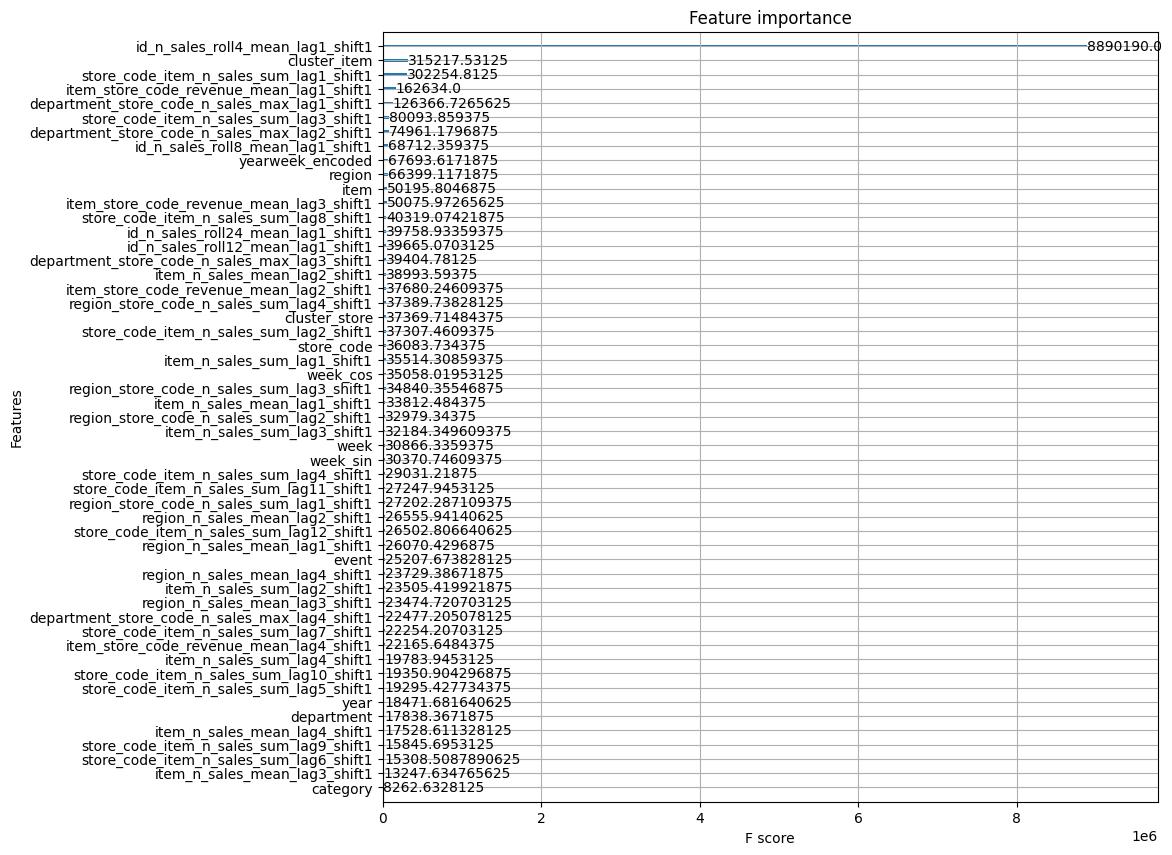

In [167]:
fig, ax = plt.subplots(figsize = (10, 10))
xgb.plot_importance(model_s_2, importance_type = "gain", ax = ax)

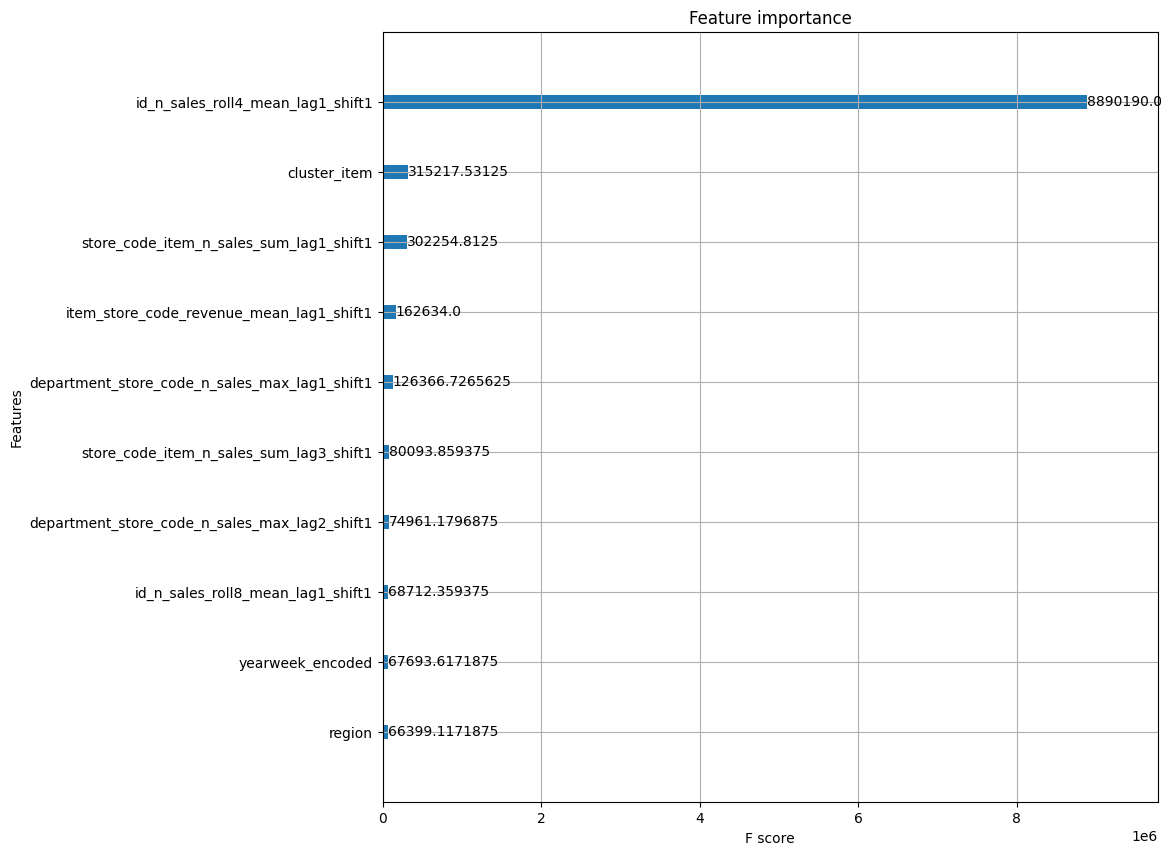

In [168]:
fig, ax = plt.subplots(figsize=(10, 10))
xgb.plot_importance(model_s_2, 
                    importance_type="gain", 
                    ax=ax, 
                    max_num_features=10)
plt.show()

### Modelo para predicción en si

Entrenamos el modelo hasta la última semana conocida del df con shift

In [169]:
model_s_2.fit(
    X_train_pred_2, y_train_pred_2
)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.95, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.03, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=600, n_jobs=None,
             num_parallel_tree=None, random_state=175, ...)

Predecimos la segunda semana

In [170]:
Y_pred_predict_2 = model_s_2.predict(X_pred_2)
Y_pred_predict_2

array([ 4.3102965 ,  0.60764176,  6.6475754 , ..., 69.33332   ,
        7.6320434 ,  0.64683986], shape=(30490,), dtype=float32)

Separamos el df para juntarle luego los valores

In [171]:
df_ventas_predict_2 = df_copy[df_copy["date"]==predict_2_weeks]

Eliminamos la original que tenía valor 0

In [172]:
df_ventas_predict_2.drop(columns="n_sales", inplace=True)

C:\Users\pablo.giner.eurostar\AppData\Local\Temp\ipykernel_31576\1195447149.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ventas_predict_2.drop(columns="n_sales", inplace=True)


In [173]:
X_pred_2.reset_index(inplace=True)

Unimos con los datos de la predicción

In [174]:
df_prediction_2 = pd.DataFrame({
    'id': X_pred_2['id'],          # toma el id original
    'n_sales': Y_pred_predict_2  # agrega las predicciones
})

In [175]:
df_prediction_2.reset_index()

index                         id    n_sales
0          0    SUPERMARKET_2_062_PHI_1   4.310297
1          1     ACCESORIES_1_136_PHI_2   0.607642
2          2  HOME_&_GARDEN_1_146_NYC_2   6.647575
3          3    SUPERMARKET_3_208_NYC_3  15.114731
4          4    SUPERMARKET_3_043_PHI_3   3.313421
...      ...                        ...        ...
30485  30485  HOME_&_GARDEN_1_230_NYC_1   1.657154
30486  30486    SUPERMARKET_1_021_BOS_1   3.742357
30487  30487    SUPERMARKET_2_181_NYC_3  69.333321
30488  30488  HOME_&_GARDEN_1_301_PHI_2   7.632043
30489  30489  HOME_&_GARDEN_2_091_PHI_3   0.646840

[30490 rows x 3 columns]

Creamos el data set de predicción

In [176]:
df_prediction_2 = df_prediction_2.merge(
    df_ventas_predict_2,
    on='id',
    how='left'  # usa 'left' para mantener todos los ids de df_prediction
)

Eliminamos valores predichos negativos

In [177]:
df_prediction_2["n_sales"] = df_prediction_2["n_sales"].clip(lower=0)

Eliminamos revenue para recalcularlo después

In [178]:
df_prediction_2.drop(columns="revenue", inplace=True)

Redondeamos predicciones

In [179]:
df_prediction_2["n_sales"] = round(df_prediction_2["n_sales"],0).astype(int)

Recalculamos revenue para todos los registros

In [180]:
df_prediction_2["revenue"] = df_prediction_2["n_sales"] * df_prediction_2["avg_sell_price"]

Unimos con el completo y las columnas que nos interesan

In [181]:
df_nuevo = df_nuevo.merge(
    df_prediction_2[["id",'yearweek','revenue', 'avg_sell_price', 'n_sales']],
    on=['id', 'yearweek'],
    how='left',
    suffixes=('', '_predict')
)

Creamos una columna temporal combinada con los previos y las predicciones

In [182]:
df_nuevo['n_sales_predict'] = df_nuevo['n_sales_predict'].fillna(df_nuevo['n_sales'])
df_nuevo['avg_sell_price_predict'] = df_nuevo['avg_sell_price_predict'].fillna(df_nuevo['avg_sell_price'])
df_nuevo['revenue_predict'] = df_nuevo['revenue_predict'].fillna(df_nuevo['revenue'])

In [183]:
df_nuevo_copy = df_nuevo.copy()

Eliminamos los anteriores

In [184]:
df_nuevo.drop(columns="n_sales", inplace=True)
df_nuevo.drop(columns="avg_sell_price", inplace=True)
df_nuevo.drop(columns="revenue", inplace=True)

Metemos los valores de la columna temporal combinada

In [185]:
df_nuevo["n_sales"] = df_nuevo['n_sales_predict']
df_nuevo["avg_sell_price"] = df_nuevo['avg_sell_price_predict']
df_nuevo["revenue"] = df_nuevo['revenue_predict']

Eliminamos la temporal combinada

In [186]:
df_nuevo.drop(columns="n_sales_predict", inplace=True)
df_nuevo.drop(columns="avg_sell_price_predict", inplace=True)
df_nuevo.drop(columns="revenue_predict", inplace=True)

Cogemos las columnas que nos interesan

In [187]:
df_nuevo = df_nuevo[["id", "item", "category", "department", "store_code", "region", "yearweek", "avg_sell_price", "event", "cluster_store", "cluster_item", "n_sales", "date", "revenue"]]

Generamos el df de predicción semana 2

In [188]:
df_prediction_2 = df_nuevo.copy()

## Predicción tercera semana

### Modelo para validar error

Definimos modelo

In [189]:
model_s_3 = xgb.XGBRegressor(
    n_estimators=600,        
    learning_rate=0.03,    
    max_depth=10,          
    subsample=0.95,        
    colsample_bytree=0.95,     
    min_child_weight=1,       
    gamma=0,                 
    reg_lambda=0.5,           
    reg_alpha=0,             
    eval_metric="rmse",
    random_state=175 
)

Entrenamos con el último set de validación para poder comparar

In [190]:
model_s_3.fit(
    X_train_3_shift, y_train_3_shift,
    eval_set=[(X_train_3_shift, y_train_3_shift), (X_test_3_shift, y_test_3_shift)]
)

[0]	validation_0-rmse:25.69004	validation_1-rmse:19.98750
[1]	validation_0-rmse:25.09805	validation_1-rmse:19.45000
[2]	validation_0-rmse:24.52253	validation_1-rmse:18.94719
[3]	validation_0-rmse:23.97046	validation_1-rmse:18.45001
[4]	validation_0-rmse:23.43586	validation_1-rmse:17.96238
[5]	validation_0-rmse:22.92396	validation_1-rmse:17.49454
[6]	validation_0-rmse:22.42549	validation_1-rmse:17.05576
[7]	validation_0-rmse:21.94690	validation_1-rmse:16.62681
[8]	validation_0-rmse:21.48614	validation_1-rmse:16.20603
[9]	validation_0-rmse:21.04124	validation_1-rmse:15.80450
[10]	validation_0-rmse:20.61338	validation_1-rmse:15.41796
[11]	validation_0-rmse:20.21429	validation_1-rmse:15.05256
[12]	validation_0-rmse:19.81859	validation_1-rmse:14.70462
[13]	validation_0-rmse:19.43736	validation_1-rmse:14.36235
[14]	validation_0-rmse:19.07075	validation_1-rmse:14.03703
[15]	validation_0-rmse:18.71788	validation_1-rmse:13.73246
[16]	validation_0-rmse:18.37812	validation_1-rmse:13.43046
[17]	va

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.95, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.03, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=600, n_jobs=None,
             num_parallel_tree=None, random_state=175, ...)

#### Feature importance

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

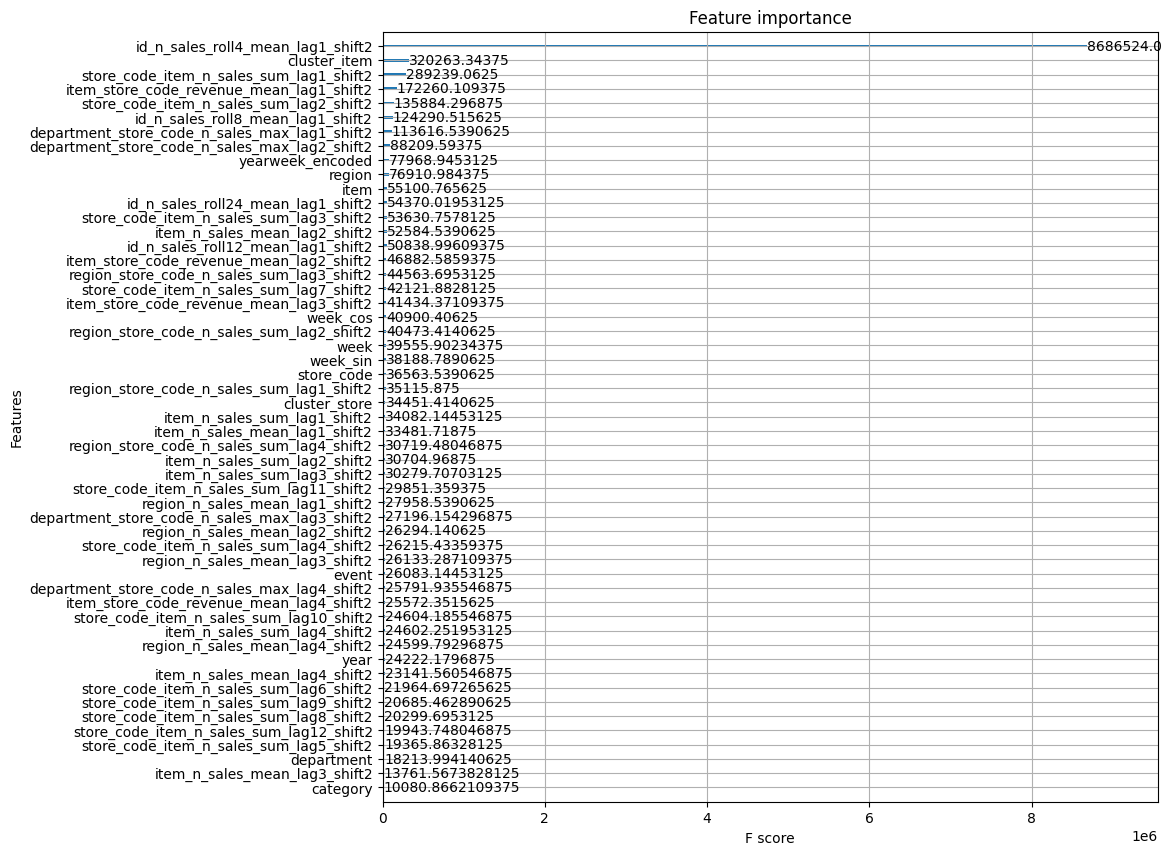

In [191]:
fig, ax = plt.subplots(figsize = (10, 10))
xgb.plot_importance(model_s_3, importance_type = "gain", ax = ax)

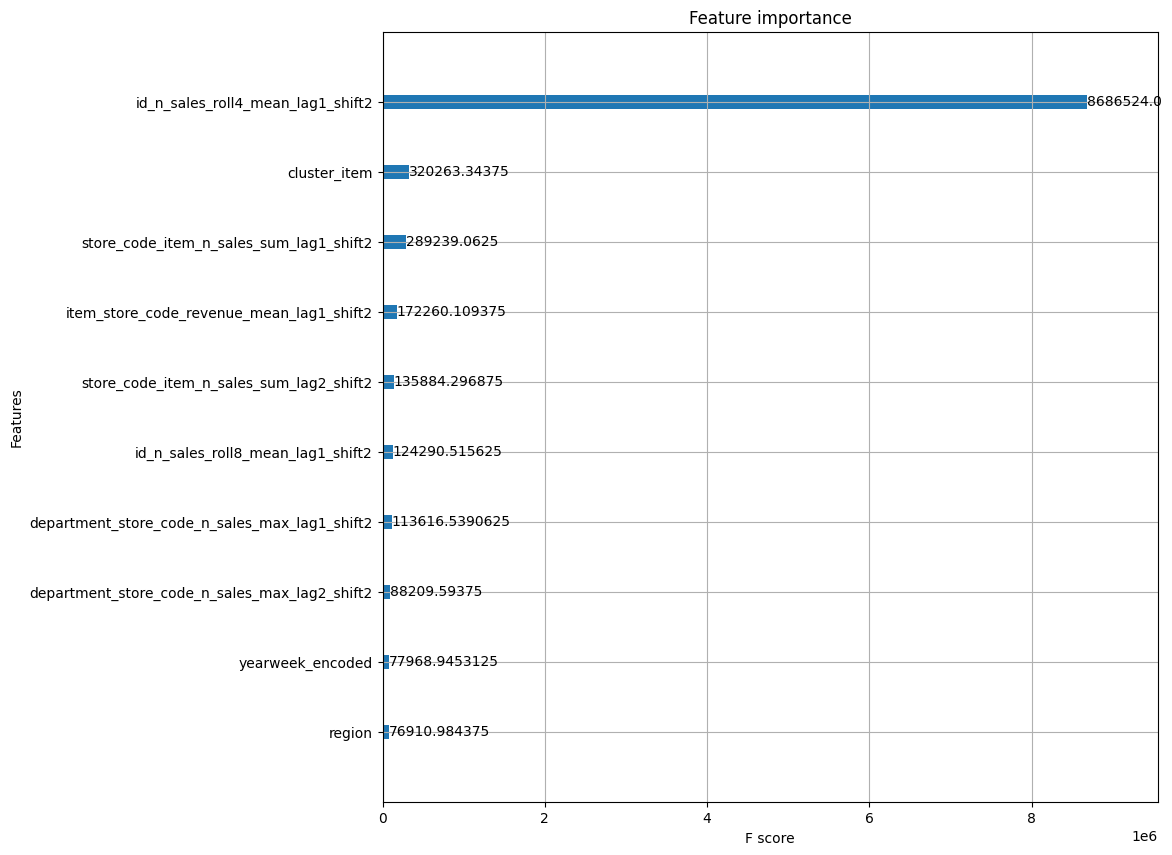

In [192]:

fig, ax = plt.subplots(figsize=(10, 10))
xgb.plot_importance(model_s_3, 
                    importance_type="gain", 
                    ax=ax, 
                    max_num_features=10)
plt.show()

### Modelo para predicción en si

In [193]:
model_s_3.fit(
    X_train_pred_3, y_train_pred_3
)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.95, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.03, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=600, n_jobs=None,
             num_parallel_tree=None, random_state=175, ...)

Predecimos la semana 3

In [194]:
Y_pred_predict_3 = model_s_3.predict(X_pred_3)
Y_pred_predict_3

array([ 4.241184 ,  5.503573 ,  8.607456 , ...,  2.1426847,  2.58726  ,
       48.956604 ], shape=(30490,), dtype=float32)

Separamos del original para incluir los datos de la predicción

In [195]:
df_ventas_predict_3 = df_copy[df_copy["date"]==predict_3_weeks]

Eliminamos la columna original con valor 0

In [196]:
df_ventas_predict_3.drop(columns="n_sales", inplace=True)

C:\Users\pablo.giner.eurostar\AppData\Local\Temp\ipykernel_31576\3612187110.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ventas_predict_3.drop(columns="n_sales", inplace=True)


In [197]:
X_pred_3.reset_index(inplace=True)

Unimos con el resultado de la predicción

In [198]:
df_prediction_3 = pd.DataFrame({
    'id': X_pred_3['id'],          # toma el id original
    'n_sales': Y_pred_predict_3  # agrega las predicciones
})

In [199]:
df_prediction_3.reset_index()

index                         id    n_sales
0          0    SUPERMARKET_1_039_NYC_1   4.241184
1          1  HOME_&_GARDEN_1_220_BOS_1   5.503573
2          2    SUPERMARKET_2_282_BOS_2   8.607456
3          3  HOME_&_GARDEN_1_204_PHI_3   4.259071
4          4    SUPERMARKET_1_066_BOS_3   4.197275
...      ...                        ...        ...
30485  30485    SUPERMARKET_2_244_PHI_3  13.481627
30486  30486     ACCESORIES_2_077_NYC_3   0.757089
30487  30487    SUPERMARKET_2_335_BOS_2   2.142685
30488  30488    SUPERMARKET_2_206_BOS_3   2.587260
30489  30489  HOME_&_GARDEN_1_399_BOS_3  48.956604

[30490 rows x 3 columns]

Unimos con el completo creando el df de predicción de semana 3

In [200]:
df_prediction_3 = df_prediction_3.merge(
    df_ventas_predict_3,
    on='id',
    how='left'  # usa 'left' para mantener todos los ids de df_prediction
)

Eliminamos valores negativos predichos

In [201]:
df_prediction_3["n_sales"] = df_prediction_3["n_sales"].clip(lower=0)

Eliminamos revenue para recalcularlo en todas

In [202]:
df_prediction_3.drop(columns="revenue", inplace=True)

Redondeamos la predicción

In [203]:
df_prediction_3["n_sales"] = round(df_prediction_3["n_sales"],0).astype(int)

Recalculamos revenue para todas

In [204]:
df_prediction_3["revenue"] = df_prediction_3["n_sales"] * df_prediction_3["avg_sell_price"]

Creamos el df conjunto hasta la semana +3

In [205]:
df_nuevo = df_nuevo.merge(
    df_prediction_3[["id",'yearweek','revenue', 'avg_sell_price', 'n_sales']],
    on=['id', 'yearweek'],
    how='left',
    suffixes=('', '_predict')
)

Rellenamos la columna auxiliar con el conjunto total

In [206]:
df_nuevo['n_sales_predict'] = df_nuevo['n_sales_predict'].fillna(df_nuevo['n_sales'])
df_nuevo['avg_sell_price_predict'] = df_nuevo['avg_sell_price_predict'].fillna(df_nuevo['avg_sell_price'])
df_nuevo['revenue_predict'] = df_nuevo['revenue_predict'].fillna(df_nuevo['revenue'])

In [207]:
df_nuevo_copy = df_nuevo.copy()

Eliminamos la columna original

In [208]:
df_nuevo.drop(columns="n_sales", inplace=True)
df_nuevo.drop(columns="avg_sell_price", inplace=True)
df_nuevo.drop(columns="revenue", inplace=True)

Sustituimos con la auxiliar

In [209]:
df_nuevo["n_sales"] = df_nuevo['n_sales_predict']
df_nuevo["avg_sell_price"] = df_nuevo['avg_sell_price_predict']
df_nuevo["revenue"] = df_nuevo['revenue_predict']

Eliminamos la auxiliar

In [210]:
df_nuevo.drop(columns="n_sales_predict", inplace=True)
df_nuevo.drop(columns="avg_sell_price_predict", inplace=True)
df_nuevo.drop(columns="revenue_predict", inplace=True)

Cogemos las columnas que queremos conservar

In [211]:
df_nuevo = df_nuevo[["id", "item", "category", "department", "store_code", "region", "yearweek", "avg_sell_price", "event", "cluster_store", "cluster_item", "n_sales", "date", "revenue"]]

Extraemos el df de predicción 3

In [212]:
df_prediction_3 = df_nuevo.copy()

## Predicción cuarta semana

Definimos el modelo

In [213]:
model_s_4 = xgb.XGBRegressor(
    n_estimators=600,        
    learning_rate=0.03,    
    max_depth=10,          
    subsample=0.95,        
    colsample_bytree=0.95,     
    min_child_weight=1,       
    gamma=0,                 
    reg_lambda=0.5,           
    reg_alpha=0,             
    eval_metric="rmse",
    random_state=175
)

Entrenamos con el último set de validación para comprobar el error

In [214]:
model_s_4.fit(
    X_train_4_shift, y_train_4_shift,
    eval_set=[(X_train_4_shift, y_train_4_shift), (X_test_4_shift, y_test_4_shift)]
)

[0]	validation_0-rmse:25.70161	validation_1-rmse:20.01371
[1]	validation_0-rmse:25.11703	validation_1-rmse:19.49499
[2]	validation_0-rmse:24.55051	validation_1-rmse:18.99910
[3]	validation_0-rmse:24.00892	validation_1-rmse:18.50020
[4]	validation_0-rmse:23.48626	validation_1-rmse:18.02697
[5]	validation_0-rmse:22.98230	validation_1-rmse:17.55489
[6]	validation_0-rmse:22.49362	validation_1-rmse:17.12291
[7]	validation_0-rmse:22.02387	validation_1-rmse:16.71376
[8]	validation_0-rmse:21.57153	validation_1-rmse:16.31326
[9]	validation_0-rmse:21.13653	validation_1-rmse:15.91990
[10]	validation_0-rmse:20.71720	validation_1-rmse:15.53628
[11]	validation_0-rmse:20.32680	validation_1-rmse:15.17600
[12]	validation_0-rmse:19.93842	validation_1-rmse:14.82488
[13]	validation_0-rmse:19.56450	validation_1-rmse:14.49706
[14]	validation_0-rmse:19.20626	validation_1-rmse:14.18441
[15]	validation_0-rmse:18.86252	validation_1-rmse:13.87911
[16]	validation_0-rmse:18.53088	validation_1-rmse:13.57554
[17]	va

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.95, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.03, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=600, n_jobs=None,
             num_parallel_tree=None, random_state=175, ...)

#### Feature importance

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

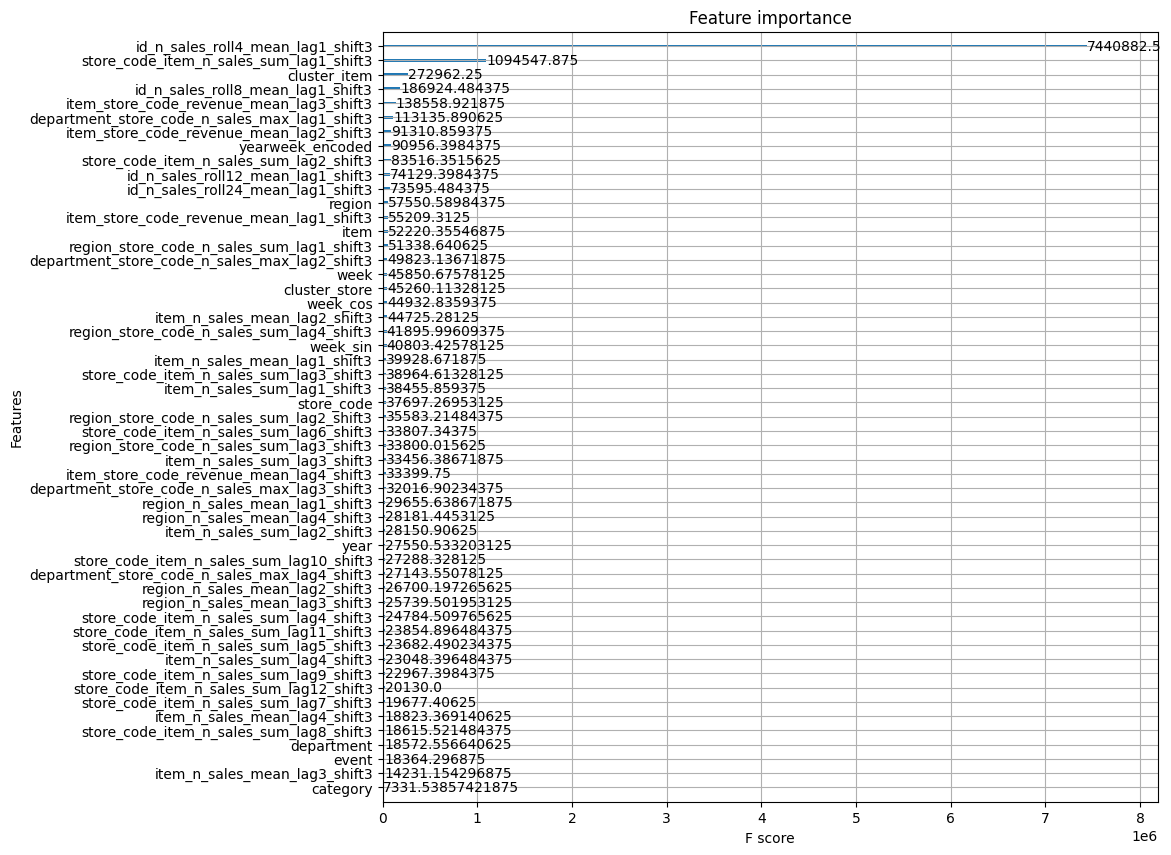

In [215]:
fig, ax = plt.subplots(figsize = (10, 10))
xgb.plot_importance(model_s_4, importance_type = "gain", ax = ax)

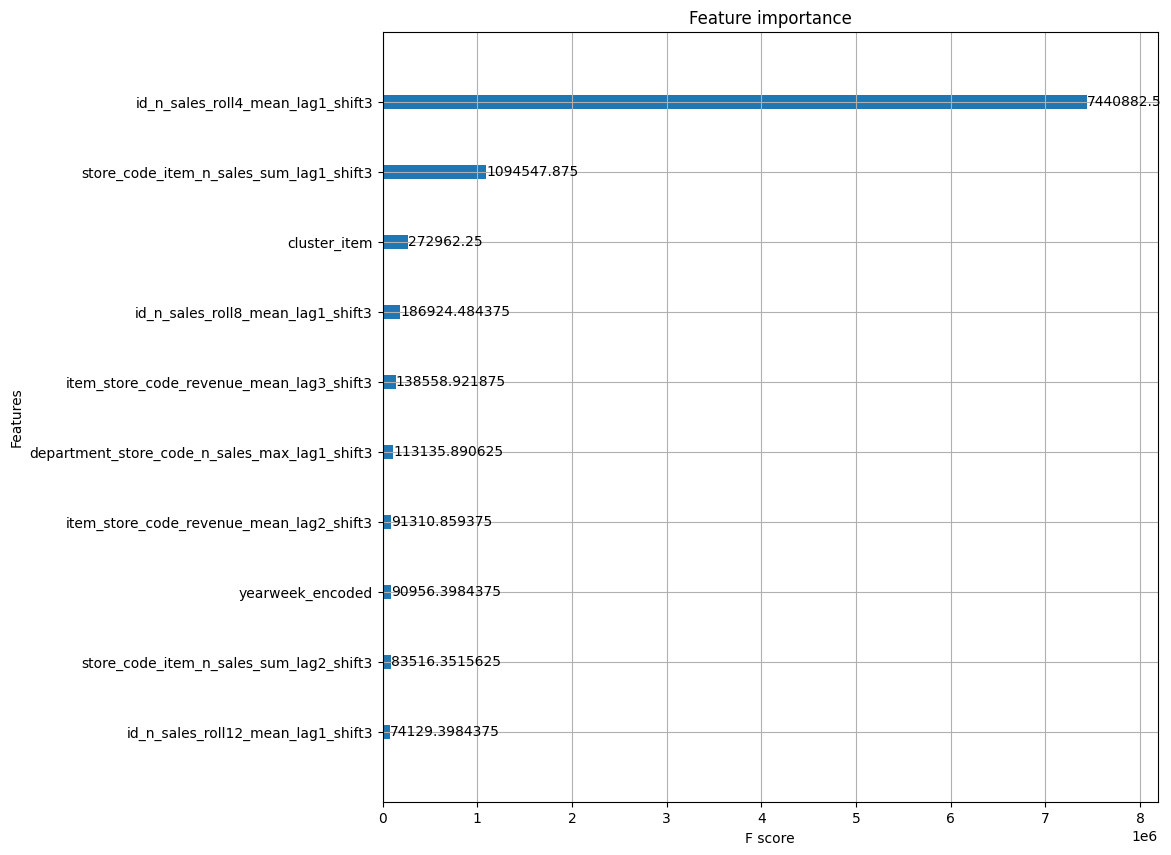

In [216]:
fig, ax = plt.subplots(figsize=(10, 10))
xgb.plot_importance(model_s_4, 
                    importance_type="gain", 
                    ax=ax, 
                    max_num_features=10)
plt.show()

Entrenamos con todas las semanas disponibles

In [217]:
model_s_4.fit(
    X_train_pred_4, y_train_pred_4
)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.95, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.03, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=600, n_jobs=None,
             num_parallel_tree=None, random_state=175, ...)

Predecimos la semana +4

In [218]:
Y_pred_predict_4 = model_s_4.predict(X_pred_4)
Y_pred_predict_4

array([ 5.8454766,  6.1580596,  7.433018 , ..., 14.4829   ,  0.7896315,
       10.273093 ], shape=(30490,), dtype=float32)

Separamos el df original para unir los datos de predicción

In [219]:
df_ventas_predict_4 = df_copy[df_copy["date"]==predict_4_weeks]

Eliminamos la columna con valor 0

In [220]:
df_ventas_predict_4.drop(columns="n_sales", inplace=True)

C:\Users\pablo.giner.eurostar\AppData\Local\Temp\ipykernel_31576\747666607.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ventas_predict_4.drop(columns="n_sales", inplace=True)


In [221]:
X_pred_4.reset_index(inplace=True)

Unimos los datos de la predicción

In [222]:
df_prediction_4 = pd.DataFrame({
    'id': X_pred_4['id'],          # toma el id original
    'n_sales': Y_pred_predict_4  # agrega las predicciones
})

In [223]:
df_prediction_4.reset_index()

index                       id    n_sales
0          0  SUPERMARKET_3_806_PHI_1   5.845477
1          1  SUPERMARKET_3_806_NYC_2   6.158060
2          2  SUPERMARKET_3_810_PHI_2   7.433018
3          3  SUPERMARKET_3_806_NYC_3   2.552803
4          4  SUPERMARKET_3_806_PHI_2   8.703815
...      ...                      ...        ...
30485  30485   ACCESORIES_1_023_PHI_1   2.359511
30486  30486   ACCESORIES_1_023_NYC_4   5.175368
30487  30487   ACCESORIES_1_023_NYC_3  14.482900
30488  30488   ACCESORIES_1_018_PHI_2   0.789631
30489  30489  SUPERMARKET_3_827_PHI_3  10.273093

[30490 rows x 3 columns]

Creamos el df de predicción

In [224]:
df_prediction_4 = df_prediction_4.merge(
    df_ventas_predict_4,
    on='id',
    how='left'  # usa 'left' para mantener todos los ids de df_prediction
)

Eliminamos negativos en la predicción

In [225]:
df_prediction_4["n_sales"] = df_prediction_4["n_sales"].clip(lower=0)

Eliminamos revenue para recalcularlo completo

In [226]:
df_prediction_4.drop(columns="revenue", inplace=True)

Redondemos la predicción

In [227]:
df_prediction_4["n_sales"] = round(df_prediction_4["n_sales"],0).astype(int)

Recalculamos revenue

In [228]:
df_prediction_4["revenue"] = df_prediction_4["n_sales"] * df_prediction_4["avg_sell_price"]

Creamos el df final

In [229]:
df_nuevo = df_nuevo.merge(
    df_prediction_4[["id",'yearweek','revenue', 'avg_sell_price', 'n_sales']],
    on=['id', 'yearweek'],
    how='left',
    suffixes=('', '_predict')
)

Rellenamos la columna de auxiliar

In [230]:
df_nuevo['n_sales_predict'] = df_nuevo['n_sales_predict'].fillna(df_nuevo['n_sales'])
df_nuevo['avg_sell_price_predict'] = df_nuevo['avg_sell_price_predict'].fillna(df_nuevo['avg_sell_price'])
df_nuevo['revenue_predict'] = df_nuevo['revenue_predict'].fillna(df_nuevo['revenue'])

In [231]:
df_nuevo_copy = df_nuevo.copy()

Eliminamos la original

In [232]:
df_nuevo.drop(columns="n_sales", inplace=True)
df_nuevo.drop(columns="avg_sell_price", inplace=True)
df_nuevo.drop(columns="revenue", inplace=True)

Rellenamos con la auxiliar

In [233]:
df_nuevo["n_sales"] = df_nuevo['n_sales_predict']
df_nuevo["avg_sell_price"] = df_nuevo['avg_sell_price_predict']
df_nuevo["revenue"] = df_nuevo['revenue_predict']

Eliminamos la auxiliar

In [234]:
df_nuevo.drop(columns="n_sales_predict", inplace=True)
df_nuevo.drop(columns="avg_sell_price_predict", inplace=True)
df_nuevo.drop(columns="revenue_predict", inplace=True)

Conservamos las columnas que nos interesan

In [235]:
df_nuevo = df_nuevo[["id", "item", "category", "department", "store_code", "region", "yearweek", "avg_sell_price", "event", "cluster_store", "cluster_item", "n_sales", "date", "revenue"]]

Df final

In [236]:
df_prediction_4 = df_nuevo.copy()

In [237]:
df_prediction_4

id  item  category  department  store_code  \
0         ACCESORIES_1_001_BOS_1     0         0           0           0   
1         ACCESORIES_1_001_BOS_1     0         0           0           0   
2         ACCESORIES_1_001_BOS_1     0         0           0           0   
3         ACCESORIES_1_001_BOS_1     0         0           0           0   
4         ACCESORIES_1_001_BOS_1     0         0           0           0   
...                          ...   ...       ...         ...         ...   
8476215  SUPERMARKET_3_827_PHI_2  3048         2           6           8   
8476216  SUPERMARKET_3_827_PHI_3  3048         2           6           9   
8476217  SUPERMARKET_3_827_PHI_3  3048         2           6           9   
8476218  SUPERMARKET_3_827_PHI_3  3048         2           6           9   
8476219  SUPERMARKET_3_827_PHI_3  3048         2           6           9   

         region  yearweek  avg_sell_price  event  cluster_store  cluster_item  \
0             0    201104             NaN      0              1             0   
1             0    201105             NaN      1              1             0   
2             0    201106             NaN      0              1             0   
3             0    201107             NaN      1              1             0   
4             0    201108             NaN      0              1             0   
...         ...       ...             ...    ...            ...           ...   
8476215       2    201620             1.2      0              0             0   
8476216       2    201617             1.2      0              3             0   
8476217       2    201618             1.2      0              3             0   
8476218       2    201619             1.2      0              3             0   
8476219       2    201620             1.2      0              3             0   

         n_sales       date  revenue  
0            0.0 2011-01-24      0.0  
1            0.0 2011-01-31      0.0  
2            0.0 2011-02-07      0.0  
3            0.0 2011-02-14      0.0  
4            0.0 2011-02-21      0.0  
...          ...        ...      ...  
8476215     18.0 2016-05-16     21.6  
8476216      6.0 2016-04-25      7.2  
8476217      9.0 2016-05-02     10.8  
8476218     10.0 2016-05-09     12.0  
8476219     10.0 2016-05-16     12.0  

[8476220 rows x 14 columns]

## 11. Extracción para visualización 

Recuperamos el original para recuperar las etiquetas sin encoder

In [238]:
df_original_labels = pd.read_parquet("df_forecasting.parquet", engine="fastparquet")

In [239]:
df_original_labels = (df_original_labels.groupby("id")[["item","category","department","store","store_code","region"]]
.first()
.reset_index()
)

In [240]:
df_prediction_4.drop(columns=["item","category","department","store_code","region"], inplace=True)

In [241]:
df_prediction_4 = df_prediction_4.merge(df_original_labels, on="id", how="left")

In [242]:
df_prediction_4["region"].value_counts()

region
New York        3390488
Boston          2542866
Philadelphia    2542866
Name: count, dtype: int64

Extraemos en parquet y csv

In [243]:
df_prediction_4.to_parquet('df_prediction_4', engine='pyarrow', index=False, compression='snappy')

In [244]:
df_prediction_4.to_csv('df_prediction_4.csv')